# Import packages

In [1]:
import IPython.display as ipd

import wave
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import math

from scipy.io import wavfile as wav
import pandas as pd
import torchaudio
import soundfile as sf

import array
import math
import numpy as np
import random
import wave

from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from IPython.display import Audio
import webrtcvad
import wandb

from sklearn import metrics

In [2]:
wandb.init(project="KP", entity="rhwndqja")

wandb: Currently logged in as: rhwndqja (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Model Implementation

In [2]:
class KSL_Extractor(nn.Module):
    """Angle discriminator
    """
    def __init__(self, de_ch):
        super().__init__()
        
        self.de_ch = de_ch
        self.k = [4,4,4,4]
        self.s = [2,2,2,2]
        self.p = [1,1,1,1]
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(de_ch[3][1], de_ch[3][0], kernel_size=self.k[0], stride=self.s[0], padding=self.p[0]),
            nn.BatchNorm1d(de_ch[3][0]),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(de_ch[2][1], de_ch[2][0], kernel_size=self.k[1], stride=self.s[1], padding=self.p[1]),
            nn.BatchNorm1d(de_ch[2][0]),
            nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose1d(de_ch[1][1], de_ch[1][0], kernel_size=self.k[2], stride=self.s[2], padding=self.p[2]),
            nn.BatchNorm1d(de_ch[1][0]),
            nn.ReLU()
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose1d(de_ch[0][1], de_ch[0][0], kernel_size=self.k[3], stride=self.s[3], padding=self.p[3]),
        )
        
    def forward(self, x):
        out = self.decoder1(x)
        out = self.decoder2(out) 
        out = self.decoder3(out) 
        out = self.decoder4(out)
        return out
    
class KSL_Localizer(nn.Module):
    """Angle discriminator
    """
    def __init__(self, last_en_ch):
        super().__init__()
        self.encoder_last = nn.Sequential(
            nn.Conv1d(last_en_ch, last_en_ch, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(last_en_ch),
            nn.ReLU()
        )
        self.globalPooling = nn.AdaptiveMaxPool1d(1)   
        self.fcl = nn.Sequential(
            nn.Linear(last_en_ch, int(last_en_ch//2)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(int(last_en_ch//2), 12)
        )
        
    def forward(self, x):
        #out = self.encoder_last(x)
        out = self.globalPooling(x)
        out = out.view(out.size(0), -1)
        out = self.fcl(out).view(-1, 2, 6)
        return out[:, 0, :], out[:, 1, :]
    
    
class KSL_Detector(nn.Module):
    """Angle discriminator
    """
    def __init__(self, last_en_ch):
        super().__init__()
        self.encoder_last = nn.Sequential(
            nn.Conv1d(last_en_ch, last_en_ch, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(last_en_ch),
            nn.ReLU()
        )
        self.globalPooling = nn.AdaptiveAvgPool1d(1)   
        self.fcl = nn.Sequential(
            nn.Linear(last_en_ch, int(last_en_ch//2)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(int(last_en_ch//2), 1)
        )
        
    def forward(self, x):
        #out = self.encoder_last(x)
        out = self.globalPooling(x)
        out = out.view(out.size(0), -1)
        out = self.fcl(out)
        return out

class KeywordSpeakerLocalizer(nn.Module):
    def __init__(self, en_ch):
        super().__init__()
        self.en_ch = en_ch # [[6, 32], [32, 64] ...]
        last_ch = self.en_ch[-1][1]
        self.relu = nn.ReLU()
        
        self.encoder1 = nn.Sequential(
            nn.Conv1d(en_ch[0][0], en_ch[0][1], kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(en_ch[0][1]),
            nn.ReLU(),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(en_ch[1][0], en_ch[1][1], kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(en_ch[1][1]),
            nn.ReLU(),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(en_ch[2][0], en_ch[2][1], kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(en_ch[2][1]),
            nn.ReLU(),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv1d(en_ch[3][0], en_ch[3][1], kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(en_ch[3][1]),
            nn.ReLU()
        )
        
        self.ksl_Extractor = KSL_Extractor(self.en_ch)
        self.ksl_Localizer = KSL_Localizer(last_ch)
        self.ksl_Detector = KSL_Detector(last_ch)
        
    def forward(self, x):
        out = self.encoder1(x)
        out = self.encoder2(out)
        out = self.encoder3(out)
        out = self.encoder4(out)
        out_localizer1, out_localizer2 = self.ksl_Localizer(out)
        out_extractor = self.ksl_Extractor(out)
        out_detector = self.ksl_Detector(out)
        return out_localizer1, out_localizer2, out_extractor, out_detector

In [3]:
if __name__ == "__main__":
    encoder_ch = [[6,32], [32, 64], [64, 128], [128, 128]]
    net = KeywordSpeakerLocalizer(encoder_ch)
    print(net)
    sample = torch.randn(1, 6, 16000)
    out_localizer1, out_localizer2, out_extractor, out_detector = net(sample)
    print(f'Output of KSL_Localizer: {out_localizer1.shape}')
    print(f'Output of KSL_Localizer: {out_localizer2.shape}')
    print(f'Output of KSL_Localizer: {out_extractor.shape}')
    print(f'Output of KSL_Localizer: {out_detector.shape}')

KeywordSpeakerLocalizer(
  (relu): ReLU()
  (encoder1): Sequential(
    (0): Conv1d(6, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder4): Sequential(
    (0): Conv1d(128, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ksl_Extractor): KSL_Extractor(
    (decoder1): Sequential(
      (0): ConvTranspose1d(128, 128, kernel_size=(4,), stride=(2,), padding=

In [34]:
net = KeywordSpeakerLocalizer(encoder_ch)
summary(net.cuda(), (6, 16000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 8000]             992
       BatchNorm1d-2             [-1, 32, 8000]              64
              ReLU-3             [-1, 32, 8000]               0
            Conv1d-4             [-1, 64, 4000]          10,304
       BatchNorm1d-5             [-1, 64, 4000]             128
              ReLU-6             [-1, 64, 4000]               0
            Conv1d-7            [-1, 128, 2000]          41,088
       BatchNorm1d-8            [-1, 128, 2000]             256
              ReLU-9            [-1, 128, 2000]               0
           Conv1d-10            [-1, 128, 1000]          82,048
      BatchNorm1d-11            [-1, 128, 1000]             256
             ReLU-12            [-1, 128, 1000]               0
AdaptiveMaxPool1d-13               [-1, 128, 1]               0
           Linear-14                   

# Create data generator

In [4]:
def get_at():
    angle_table_base = np.array([
        120.0,
        60.0,
        0.0,
        300.0,
        240.0,
        180.0]
    )

    at = angle_table_base
    at = np.sort(at) 
    return at


def get_label_index(angle, at):
    label_index = 0
    angle = int(angle)
    if (angle < at[1] and angle >= at[0]):
        label_index = 0
        angle = angle / 60
    elif (angle < at[2] and angle >= at[1]):
        label_index = 1
        angle = (angle - at[1]) / 60
    elif (angle < at[3] and angle >= at[2]):
        label_index = 2
        angle = (angle - at[2]) / 60
    elif (angle < at[4] and angle >= at[3]):
        label_index = 3
        angle = (angle - at[3]) / 60
    elif (angle < at[5] and angle >= at[4]):
        label_index = 4
        angle = (angle - at[4]) / 60
    elif (angle < 360 and angle >= at[5]):
        label_index = 5
        angle = (angle - at[5]) / 60
        
    if at[label_index] == angle:
        angle = 0
    if angle == 360:
        angle = 0
    return label_index, angle

    
class AutoDataset(Dataset):
    def __init__(self, annotations_file, file_dir, target_word='sheila', transform=None, target_transform=None, DType="train"):
        
        self.file_labels = pd.read_csv(annotations_file)
        if DType == "train":
            self.file_labels = self.file_labels[10000:-10000]
        elif DType == "valid":
            self.file_labels = self.file_labels[:10000]
        elif DType == "test":
            self.file_labels = self.file_labels[-10000:]
            
        self.target_word = target_word
        self.no_target_labels = self.file_labels[~self.file_labels['fileName'].str.contains(self.target_word)]
        self.only_target_labels = self.file_labels[self.file_labels['fileName'].str.contains(self.target_word)]
        self.tar_idxs = len(self.only_target_labels)
        self.vic_idxs = len(self.no_target_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        self.n_classes = 6
        self.at = get_at()
        self.respeaker_mic = np.array([
            [-0.02315, 0.04009,1], # 120 degree
            [0.02315, 0.04009,1],  # 60 degree
            [0.04629, 0.0,1],      # 0 degree
            [0.02315,-0.04009,1],  # 300 degree
            [-0.02315,-0.04009,1], # 240 degree
            [-0.04629, 0.0,1]      # 180 degree
        ])

    def __len__(self):
        return len(self.no_target_labels)

    def __getitem__(self, idx):
        #vic = random.sample(range(self.vic_idxs), 1)[0]
        
        is_tar_in_sg = random.sample(range(2), 1)[0] # Is target in signal? 1-> yes, 0 -> no
        
        if is_tar_in_sg:
            vic1_fp = self.no_target_labels.iloc[idx, 2]
            #tar = random.sample(range(self.tar_idxs), 1)[0]
            tar = idx % self.tar_idxs
            tar_fp = self.only_target_labels.iloc[tar, 2] # target file path (fp)
            
            vic1_sg, sr = torchaudio.load(vic1_fp)
            tar_sg, sr = torchaudio.load(tar_fp)
            
            y_sg = tar_sg
            
            class_lb = 1.

            mixed_signal = torch.cat([tar_sg.unsqueeze(0), vic1_sg.unsqueeze(0)])
            #mixed_signal = vic1_sg + tar_sg
            
            x, y, z = self.only_target_labels.iloc[tar, 5:8]
            angle = int(math.atan2(float(y), float(x)) * 180 / np.pi)
            
        else:
            vic1_fp = self.no_target_labels.iloc[idx, 2]
            vic2 = random.sample(range(self.vic_idxs), 1)[0]
            vic2_fp = self.no_target_labels.iloc[vic2, 2] # victim file path (fp)
            
            vic1_sg, sr = torchaudio.load(vic1_fp)
            vic2_sg, sr = torchaudio.load(vic2_fp)
            
            y_sg = vic1_sg
            
            class_lb = 0.
            mixed_signal = torch.cat([vic1_sg.unsqueeze(0), vic2_sg.unsqueeze(0)])
            #mixed_signal = vic1_sg + vic2_sg
            
            x, y, z = self.no_target_labels.iloc[idx, 5:8]
            angle = int(math.atan2(float(y), float(x)) * 180 / np.pi)
            
        #mixed_signal[mixed_signal > 1] = 1.
        #mixed_signal[mixed_signal < -1] = -1.
        
        if self.transform:
            x_sg = self.transform(mixed_signal)
        #x_sg = mixed_signal
        
        if angle < 0:
            angle = angle + 360
        y_region, y_angle = get_label_index(angle, self.at)
        
        reg = torch.tensor([y_region])
        bce = torch.zeros(len(reg), self.n_classes).scatter_(1, reg.unsqueeze(1), 1.)
        
        y_angle  = (bce * y_angle).squeeze(0)
        
        y_class = torch.tensor(class_lb)

        return x_sg.float(), y_sg.float(), y_region, y_angle, y_class, bce.squeeze(0), angle
    
class JB_Sample:
    def __init__(self, sample, vad_mode):
        self.sample = sample
        self.sample_int16 = (sample * (2**16 / 2)).numpy().astype(np.int16)
        self.vad = webrtcvad.Vad()
        self.vad.set_mode(vad_mode)
        self.chunk_num = 50
    
    def sample_vad(self):
        vad_result = []
        sample_chunk = np.reshape(self.sample_int16[:1, :].T,
                                  (self.chunk_num, 320, 1))
        for chunk in sample_chunk: 
            # Scaling Chunk
            vad_result.append(self.vad.is_speech(chunk, 16000))
        return vad_result
    
    
    def find_point(self):
        vad_result = self.sample_vad()
        start = False
        start_idx = 0
        utt_list = []
        for idx, i in enumerate(vad_result):
            if i and not start:
                start = True
                start_idx = idx

            elif i and start:
                if idx == 49:
                    utt_list.append([start_idx, idx])
                continue

            elif not i and start:
                start = False
                utt_list.append([start_idx, idx])

        biggest = 0
        if utt_list:
            for block in utt_list:
                size = block[1] - block[0]
                if size > biggest:
                    biggest = size
                    start, end = block[0], block[1]
        else:
            start, end = 0, 49
            
        return start, end
    
    def get_result(self):
        return self.sample_vad()
    
class Overlap_interference(object):
    def __init__(self, overlap, sir, bg_noise=None):
        self.overlap = overlap
        self.len_overlap = len(overlap)
        
        self.sir = sir #[0,10,20,30]
        self.len_sir = len(sir)
        
        self.vad_mode = 2
        if bg_noise:
            self.bg_noise = bg_noise
        
    def __call__(self, sample):
        # selected overlap
        overlap_idx = random.sample(range(self.len_overlap), 1)[0]
        # selected sir
        sir_idx = random.sample(range(self.len_sir), 1)[0]
        
        x1_sg, x2_sg = JB_Sample(sample[0], self.vad_mode), JB_Sample(sample[1], self.vad_mode)
        
        x1_start, x1_end = x1_sg.find_point()
        x2_start, x2_end = x2_sg.find_point()
        
        target_rms = torch.mean(torch.sqrt(torch.mean(torch.square(sample[0]), axis=0)))
        interf_rms = torch.mean(torch.sqrt(torch.mean(torch.square(sample[1]), axis=0)))
        
        sir = float(self.sir[sir_idx]) / 20
        overlap = self.overlap[overlap_idx]
        #print(f'SNR: {self.sir[sir_idx]}dB, Overlap ratio: {overlap}')
        
        ad_interf_rms = target_rms / (10 ** sir)
        ad_interf_amp = sample[1] * (ad_interf_rms / interf_rms)
        
        
        mixture = self.overlapping([sample[0], x1_start, x1_end], [sample[1], x2_start, x2_end], overlap)
        return mixture
    
    def overlapping(self, target, interf, overlap_ratio):
        # direction = front or back
        target_sg, t_start, t_end = target
        interf_sg, i_start, i_end = interf
        mixture = target_sg.clone()

        t_mid = t_start + int((t_end - t_start) / 2)
        #print(f'target start {t_start}, target mid {t_mid}, target end {t_end}')
        i_mid = i_start + int((i_end - i_start) / 2)
        #print(f'interf start {i_start}, interf mid {i_mid}, interf end {i_end}')

        ignore = False
        margin_start, margin_end = 0, 0
        pm = 0
        diff = t_mid - i_mid
        if diff >= 0:
            pm = 1
        elif diff < 0:
            pm = -1

        if overlap_ratio == 1.0:
            diff = t_mid - i_mid
        elif overlap_ratio == 0.5:
            if pm > 0:
                diff = t_mid - i_end
            elif pm < 0:
                diff = t_mid - i_start
        elif overlap_ratio == 0.0:
            if pm > 0:
                diff = t_start - i_end
            elif pm < 0:
                diff = t_end - i_start
        #print(f'diff: {diff}')
        n_start = i_start + diff
        n_end = i_end + diff
        n_mid = int((n_end - n_start) / 2) + n_start

        if n_start < 0:
            margin_start = abs(n_start)
            n_start = 0

        elif n_start > 49:
            n_start = 49
            ignore = True

        if n_end < 0:
            n_end = 0
            ignore = True

        elif n_end > 49:
            margin_end = int(n_end - 49)
            n_end = 49
        #print(f'n_start:{n_start}, n_mid: {n_mid}, n_end: {n_end}')
        #print(f'm_start:{margin_start}, m_end: {margin_end}')
        #print(f'i_start:{i_start+margin_start}, i_mid: {i_mid}, i_end: {i_end-margin_end}')
        if not ignore:
            mixture[:, n_start*320:n_end*320] = target_sg[:, n_start*320:n_end*320] \
                                                 + interf_sg[:, int(i_start+margin_start)*320:int(i_end-margin_end)*320]
        mixture[mixture > 1] = 1
        mixture[mixture < -1] = -1

        return mixture

In [5]:
annotation = 'data_all.csv'
file_dir = 'data_all/'
root_dir = '../dataset'

overlap = [1.0, 0.5, 0.]
sir = [-10, 0, 10]
OL_SIR = Overlap_interference(overlap=overlap, sir=sir)
composed = transforms.Compose([OL_SIR])
target_w = "go"
dat = AutoDataset(
    annotations_file=annotation,
    file_dir=file_dir,
    target_word=target_w,
    transform=composed
)

valid = .2
test= .5
shuffle_dataset = True
random_seed= 200

dataset_size = len(dat)
indices = list(range(dataset_size))
val_split = int(np.floor(valid * dataset_size))

"""
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[val_split:], indices[:val_split]

test_split = int(np.floor(test * len(val_indices)))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(val_indices)
val_indices, test_indices = val_indices[test_split:], val_indices[:test_split]


with open('indice/train_indices_auto_go.txt', 'wb') as f:
    pickle.dump(train_indices, f)
with open('indice/val_indices_auto_go.txt', 'wb') as f:
    pickle.dump(val_indices, f)
with open('indice/test_indices_auto_go.txt', 'wb') as f:
    pickle.dump(test_indices, f)


with open('indice/train_indices_auto_go.txt', 'rb') as f:
    train_indices = pickle.load(f)
    
with open('indice/val_indices_auto_go.txt', 'rb') as f:
    val_indices = pickle.load(f)

with open('indice/test_indices_auto_go.txt', 'rb') as f:
    test_indices = pickle.load(f)


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
"""
dat_train = AutoDataset(
    annotations_file=annotation,
    file_dir=file_dir,
    target_word=target_w,
    transform=composed,
    DType="train"
)
dat_valid = AutoDataset(
    annotations_file=annotation,
    file_dir=file_dir,
    target_word=target_w,
    transform=composed,
    DType="valid"
)
dat_test = AutoDataset(
    annotations_file=annotation,
    file_dir=file_dir,
    target_word=target_w,
    transform=composed,
    DType="test"
)

batch_size= 32

train_loader = torch.utils.data.DataLoader(dat_train,
                                           batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dat_valid,
                                                batch_size=10)
test_loader = torch.utils.data.DataLoader(dat_test,
                                          batch_size=1)

In [ ]:
        if DType == "train":
            self.file_labels = self.file_labels[10000:-10000]
        elif DType == "valid":
            self.file_labels = self.file_labels[:10000]
        elif DType == "test":
            self.file_labels = self.file_labels[-10000:]

In [6]:
file_labels = pd.read_csv(annotation)
file_labels = file_labels[10000:-10000]
no_target_labels = file_labels[~file_labels['fileName'].str.contains(target_w)]
only_target_labels = file_labels[file_labels['fileName'].str.contains(target_w)]
train_indices = random.sample(range(len(no_target_labels)), len(no_target_labels))

file_labels = pd.read_csv(annotation)
file_labels = file_labels[:10000]
no_target_labels = file_labels[~file_labels['fileName'].str.contains(target_w)]
only_target_labels = file_labels[file_labels['fileName'].str.contains(target_w)]
val_indices = random.sample(range(len(no_target_labels)), len(no_target_labels))

file_labels = pd.read_csv(annotation)
file_labels = file_labels[-10000:]
no_target_labels = file_labels[~file_labels['fileName'].str.contains(target_w)]
only_target_labels = file_labels[file_labels['fileName'].str.contains(target_w)]
test_indices = random.sample(range(len(no_target_labels)), len(no_target_labels))

print(len(train_indices), len(val_indices), len(test_indices))

72641 9627 9648


In [7]:
def DOA(region_y, angle_y, region_p, angle_p, threshold, class_y, class_p):
    at = get_at()
    doa_err = 0.0
    doa_acc = 0
    residual = 0
    bo = 0
    count = 0
    sig = nn.Sigmoid()
    for ry, ay, rp, ap, cy, cp in zip(region_y, angle_y, region_p, angle_p, class_y, class_p):
        if cy == 1: 
            doa_y = int(at[int(ry)] + ay[int(ry)].item() * 60)

            rp_idx = int(torch.argmax(rp))
            doa_p = int(at[rp_idx] + sig(ap[rp_idx]) * 60)
            #print(doa_p)
            
            if doa_p > 360:
                doa_p = doa_p - 360
            elif doa_p < 0:
                doa_p = 360 + doa_p

            residual = abs(doa_y - doa_p)
            if residual > 180:
                residual = 360 - residual
            doa_err += residual

            if residual <= threshold:
                bo = 1
            else:
                bo = 0
            doa_acc += bo
            count += 1
        else:
            continue
    return doa_err, doa_acc, count

In [8]:
import datetime

t = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")[:-3] + "Drop"
weight_dir = 'weight/' + t
sample_dir = 'samples/' + t

os.mkdir(weight_dir)
os.mkdir(sample_dir)
os.mkdir(sample_dir + '_val')
coarse_loss = nn.CrossEntropyLoss()
fine_loss = nn.MSELoss(reduction="sum")
cls_loss = nn.BCELoss(reduction="sum")
ext_loss = nn.L1Loss(reduction="sum")

encoder_ch = [[6,32],[32,96],[96,192],[192,192]]
net = KeywordSpeakerLocalizer(encoder_ch).cuda()
learning_rate = 0.00001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,25], gamma=0.1)

accuracy = 0.0
loss = 0
CoarW = 0.
FineW = 0.
ExtW = 0.
ClsW = 1.

coeff_total = CoarW + FineW + ExtW + ClsW
CoarW = CoarW / coeff_total
FineW = FineW / coeff_total
ExtW = ExtW / coeff_total
ClsW = ClsW / coeff_total

In [9]:
wandb.init(
    project="KP", 
    name=f"{t}", 
    config={
        "learning_rate": learning_rate,
        "architecture": "Multi-task",
        "Overlap_ratio": overlap,
        "SIR ratio": sir,
        "coar fine cls ext": [CoarW, FineW, ClsW, ExtW], 
        "Date": t + "_new_go",
        "epochs": 30,
        "encoder_ch": encoder_ch
})
#wandb.watch(net)


wandb: Currently logged in as: rhwndqja (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [10]:
b1 = 0
b2 = 0
for epoch in range(1, 31):
    net.train()
    running_loss = 0.0
    tloss_ext = 0.
    tloss_cls = 0.
    tloss_coar = 0.
    tloss_fine = 0.
    total_loss = 0.0
    
    for batch_index, (x_sg, y_sg, y_region, y_angle, y_class, bce, _) in enumerate(train_loader):
        
        x_sg = x_sg.cuda()
        y_sg = y_sg.cuda()
        y_region = y_region.cuda()
        y_angle = y_angle.cuda()
        y_class = y_class.cuda()
        bce = bce.cuda()

        optimizer.zero_grad()

        out_localizer1, out_localizer2, out_extractor, out_detector = net(x_sg)
        
        loss_ext = ExtW * ext_loss(y_class.unsqueeze(1).unsqueeze(1) * torch.tanh(out_extractor), y_sg)
        loss_cls = ClsW * cls_loss(torch.sigmoid(out_detector), y_class.unsqueeze(1))
        loss_coarse = CoarW * coarse_loss(y_class.unsqueeze(1) * out_localizer1, (y_class * y_region).long())
        loss_fine = FineW * fine_loss(y_class.unsqueeze(1) * bce * torch.sigmoid(out_localizer2), y_class.unsqueeze(1) * y_angle)
        
        loss = loss_ext + loss_cls + \
            loss_coarse + loss_fine
            
        loss.backward()
        optimizer.step()
        
        tloss_ext += loss_ext.item()
        tloss_cls += loss_cls.item()
        tloss_coar += loss_coarse.item()
        tloss_fine += loss_fine.item()
        
        running_loss += loss.item()
        if batch_index % 10 == 9:
            print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
                running_loss / (9 * batch_size),
                optimizer.param_groups[0]['lr'],
                epoch=epoch,
                trained_samples=batch_index * batch_size + len(x_sg),
                total_samples=len(train_indices)
            ))
            running_loss = 0.0
            wandb.log({"train/Train_loss_coar": tloss_coar / (batch_size * 10),
               "train/Train_loss_fine": tloss_fine / (batch_size * 10),
               "train/Train_loss_cls": tloss_cls / (batch_size * 10),
               "train/Train_loss_ext": tloss_ext / (batch_size * 10)},
                      step = b1)
            tloss_ext = 0.0
            tloss_cls = 0.0
            tloss_coar = 0.0
            tloss_fine = 0.0
            b1 += 1
        
    """
    for sample_idx in range(5):
        name_xg = f'{sample_dir}/{epoch}_xg_{sample_idx}.wav'
        name_yg = f'{sample_dir}/{epoch}_yg_{sample_idx}.wav'
        
        torchaudio.save(name_xg, x_sg[sample_idx].cpu(), 16000)
        torchaudio.save(name_yg, y_sg[sample_idx].cpu(), 16000)
    """
    
    scheduler.step()
    
    net.eval()
    accuracy = 0.0
    class_acc = 0.0
    doa_err = 0.0
    doa_acc = 0.0
    count = 0.0
    tloss_ext = 0.
    tloss_cls = 0.
    tloss_coar = 0.
    tloss_fine = 0.
    total_loss = 0.0
    for batch_index, (x_sg, y_sg, y_region, y_angle, y_class, bce, _) in enumerate(validation_loader):
        x_sg = x_sg.cuda()
        y_sg = y_sg.cuda()
        y_region = y_region.cuda()
        y_angle = y_angle.cuda()
        y_class = y_class.cuda()
        bce = bce.cuda()

        out_localizer1, out_localizer2, out_extractor, out_detector = net(x_sg)
        loss_ext = ExtW * ext_loss(y_class.unsqueeze(1).unsqueeze(1) * torch.tanh(out_extractor), y_sg)
        loss_cls = ClsW * cls_loss(torch.sigmoid(out_detector), y_class.unsqueeze(1))
        loss_coarse = CoarW * coarse_loss(y_class.unsqueeze(1) * out_localizer1, (y_class * y_region).long())
        loss_fine = FineW * fine_loss(y_class.unsqueeze(1) * bce * torch.sigmoid(out_localizer2), y_class.unsqueeze(1) * y_angle)
        
        tloss_ext += loss_ext.item()
        tloss_cls += loss_cls.item()
        tloss_coar += loss_coarse.item()
        tloss_fine += loss_fine.item()
        
        loss = loss_ext + loss_cls + loss_coarse + loss_fine
        
        total_loss += loss.item()
        _, region_pidx = out_localizer1.max(1)
        accuracy += region_pidx.eq(y_region).sum()
        
        class_acc += (torch.sigmoid(out_detector) > 0.5).squeeze(1).eq(y_class).sum()
        a, b, c = DOA(y_region, y_angle, out_localizer1, out_localizer2, 20, y_class, torch.sigmoid(out_detector))
        
        doa_err += a
        doa_acc += b
        count += c
        
    wandb.log({"val/Val_loss_coar": tloss_coar / len(val_indices),
               "val/Val_loss_fine": tloss_fine / len(val_indices),
               "val/Val_loss_cls": tloss_cls / len(val_indices),
               "val/Val_loss_ext": tloss_ext / len(val_indices),
               "val/Val_Cls_acc": class_acc.float() / len(val_indices),
               "val/Val_doa_acc": doa_acc / count,
               "val/Val_doa_err": doa_err / count},
             commit = False)
    b2 += 1
    print('Val Result: Acc: {:0.4f}, C_ACC: {:0.4f}, DOA: {:0.4f}, ACC_k: {:0.4f}'.format(
        accuracy.float() / len(val_indices),
        class_acc.float() / len(val_indices),
        doa_err / count,
        doa_acc / count
    ))
    print(f'ext:{round(tloss_ext/len(val_indices), 6)}, cls:{round(tloss_cls/len(val_indices), 6)}, coar:{round(tloss_coar/len(val_indices), 6)}, fine:{round(tloss_fine/len(val_indices), 6)},')
    weight_path = os.path.join(weight_dir, str(epoch) + '.pt')
    torch.save(net.state_dict(), weight_path, _use_new_zipfile_serialization=False)
    
    """
    for sample_idx in range(4):
        parent_path = os.path.join('samples', t + '_val')
        name_gen = f'{parent_path}/{epoch}_gen_{sample_idx}.wav'
        name_mixed = f'{parent_path}/{epoch}_mix_{sample_idx}.wav'
        name_target = f'{parent_path}/{epoch}_target_{sample_idx}.wav'
        torchaudio.save(name_gen, torch.tanh(out_extractor)[sample_idx].cpu(), 16000)
        torchaudio.save(name_mixed, x_sg[sample_idx].cpu(), 16000)
        torchaudio.save(name_target, y_sg[sample_idx].cpu(), 16000)
    """

Training Epoch: 1 [320/72641]	Loss: 0.7683	LR: 0.000010
Training Epoch: 1 [640/72641]	Loss: 0.7698	LR: 0.000010
Training Epoch: 1 [960/72641]	Loss: 0.7617	LR: 0.000010
Training Epoch: 1 [1280/72641]	Loss: 0.7803	LR: 0.000010
Training Epoch: 1 [1600/72641]	Loss: 0.7752	LR: 0.000010
Training Epoch: 1 [1920/72641]	Loss: 0.7723	LR: 0.000010
Training Epoch: 1 [2240/72641]	Loss: 0.7665	LR: 0.000010
Training Epoch: 1 [2560/72641]	Loss: 0.7685	LR: 0.000010
Training Epoch: 1 [2880/72641]	Loss: 0.7693	LR: 0.000010
Training Epoch: 1 [3200/72641]	Loss: 0.7662	LR: 0.000010
Training Epoch: 1 [3520/72641]	Loss: 0.7665	LR: 0.000010
Training Epoch: 1 [3840/72641]	Loss: 0.7612	LR: 0.000010
Training Epoch: 1 [4160/72641]	Loss: 0.7642	LR: 0.000010
Training Epoch: 1 [4480/72641]	Loss: 0.7612	LR: 0.000010
Training Epoch: 1 [4800/72641]	Loss: 0.7706	LR: 0.000010
Training Epoch: 1 [5120/72641]	Loss: 0.7658	LR: 0.000010
Training Epoch: 1 [5440/72641]	Loss: 0.7691	LR: 0.000010
Training Epoch: 1 [5760/72641]	Los

Training Epoch: 1 [45760/72641]	Loss: 0.7220	LR: 0.000010
Training Epoch: 1 [46080/72641]	Loss: 0.7262	LR: 0.000010
Training Epoch: 1 [46400/72641]	Loss: 0.7408	LR: 0.000010
Training Epoch: 1 [46720/72641]	Loss: 0.7223	LR: 0.000010
Training Epoch: 1 [47040/72641]	Loss: 0.7236	LR: 0.000010
Training Epoch: 1 [47360/72641]	Loss: 0.7250	LR: 0.000010
Training Epoch: 1 [47680/72641]	Loss: 0.7323	LR: 0.000010
Training Epoch: 1 [48000/72641]	Loss: 0.7175	LR: 0.000010
Training Epoch: 1 [48320/72641]	Loss: 0.7389	LR: 0.000010
Training Epoch: 1 [48640/72641]	Loss: 0.7262	LR: 0.000010
Training Epoch: 1 [48960/72641]	Loss: 0.7542	LR: 0.000010
Training Epoch: 1 [49280/72641]	Loss: 0.7487	LR: 0.000010
Training Epoch: 1 [49600/72641]	Loss: 0.7490	LR: 0.000010
Training Epoch: 1 [49920/72641]	Loss: 0.7129	LR: 0.000010
Training Epoch: 1 [50240/72641]	Loss: 0.7275	LR: 0.000010
Training Epoch: 1 [50560/72641]	Loss: 0.7153	LR: 0.000010
Training Epoch: 1 [50880/72641]	Loss: 0.7639	LR: 0.000010
Training Epoch

Training Epoch: 2 [17920/72641]	Loss: 0.7164	LR: 0.000010
Training Epoch: 2 [18240/72641]	Loss: 0.7258	LR: 0.000010
Training Epoch: 2 [18560/72641]	Loss: 0.7345	LR: 0.000010
Training Epoch: 2 [18880/72641]	Loss: 0.6957	LR: 0.000010
Training Epoch: 2 [19200/72641]	Loss: 0.6954	LR: 0.000010
Training Epoch: 2 [19520/72641]	Loss: 0.7296	LR: 0.000010
Training Epoch: 2 [19840/72641]	Loss: 0.7324	LR: 0.000010
Training Epoch: 2 [20160/72641]	Loss: 0.6985	LR: 0.000010
Training Epoch: 2 [20480/72641]	Loss: 0.7151	LR: 0.000010
Training Epoch: 2 [20800/72641]	Loss: 0.7176	LR: 0.000010
Training Epoch: 2 [21120/72641]	Loss: 0.7397	LR: 0.000010
Training Epoch: 2 [21440/72641]	Loss: 0.7357	LR: 0.000010
Training Epoch: 2 [21760/72641]	Loss: 0.7147	LR: 0.000010
Training Epoch: 2 [22080/72641]	Loss: 0.7200	LR: 0.000010
Training Epoch: 2 [22400/72641]	Loss: 0.7006	LR: 0.000010
Training Epoch: 2 [22720/72641]	Loss: 0.6854	LR: 0.000010
Training Epoch: 2 [23040/72641]	Loss: 0.6926	LR: 0.000010
Training Epoch

Training Epoch: 2 [63360/72641]	Loss: 0.7179	LR: 0.000010
Training Epoch: 2 [63680/72641]	Loss: 0.6922	LR: 0.000010
Training Epoch: 2 [64000/72641]	Loss: 0.7115	LR: 0.000010
Training Epoch: 2 [64320/72641]	Loss: 0.7117	LR: 0.000010
Training Epoch: 2 [64640/72641]	Loss: 0.7024	LR: 0.000010
Training Epoch: 2 [64960/72641]	Loss: 0.7020	LR: 0.000010
Training Epoch: 2 [65280/72641]	Loss: 0.7427	LR: 0.000010
Training Epoch: 2 [65600/72641]	Loss: 0.6883	LR: 0.000010
Training Epoch: 2 [65920/72641]	Loss: 0.7405	LR: 0.000010
Training Epoch: 2 [66240/72641]	Loss: 0.7047	LR: 0.000010
Training Epoch: 2 [66560/72641]	Loss: 0.7061	LR: 0.000010
Training Epoch: 2 [66880/72641]	Loss: 0.7083	LR: 0.000010
Training Epoch: 2 [67200/72641]	Loss: 0.6695	LR: 0.000010
Training Epoch: 2 [67520/72641]	Loss: 0.7186	LR: 0.000010
Training Epoch: 2 [67840/72641]	Loss: 0.7080	LR: 0.000010
Training Epoch: 2 [68160/72641]	Loss: 0.6634	LR: 0.000010
Training Epoch: 2 [68480/72641]	Loss: 0.6904	LR: 0.000010
Training Epoch

Training Epoch: 3 [35520/72641]	Loss: 0.7132	LR: 0.000010
Training Epoch: 3 [35840/72641]	Loss: 0.6930	LR: 0.000010
Training Epoch: 3 [36160/72641]	Loss: 0.7095	LR: 0.000010
Training Epoch: 3 [36480/72641]	Loss: 0.6922	LR: 0.000010
Training Epoch: 3 [36800/72641]	Loss: 0.6992	LR: 0.000010
Training Epoch: 3 [37120/72641]	Loss: 0.7093	LR: 0.000010
Training Epoch: 3 [37440/72641]	Loss: 0.7112	LR: 0.000010
Training Epoch: 3 [37760/72641]	Loss: 0.6801	LR: 0.000010
Training Epoch: 3 [38080/72641]	Loss: 0.6790	LR: 0.000010
Training Epoch: 3 [38400/72641]	Loss: 0.7187	LR: 0.000010
Training Epoch: 3 [38720/72641]	Loss: 0.7146	LR: 0.000010
Training Epoch: 3 [39040/72641]	Loss: 0.6860	LR: 0.000010
Training Epoch: 3 [39360/72641]	Loss: 0.6953	LR: 0.000010
Training Epoch: 3 [39680/72641]	Loss: 0.6947	LR: 0.000010
Training Epoch: 3 [40000/72641]	Loss: 0.7214	LR: 0.000010
Training Epoch: 3 [40320/72641]	Loss: 0.7114	LR: 0.000010
Training Epoch: 3 [40640/72641]	Loss: 0.7352	LR: 0.000010
Training Epoch

Training Epoch: 4 [7680/72641]	Loss: 0.6810	LR: 0.000010
Training Epoch: 4 [8000/72641]	Loss: 0.7140	LR: 0.000010
Training Epoch: 4 [8320/72641]	Loss: 0.7010	LR: 0.000010
Training Epoch: 4 [8640/72641]	Loss: 0.7100	LR: 0.000010
Training Epoch: 4 [8960/72641]	Loss: 0.6839	LR: 0.000010
Training Epoch: 4 [9280/72641]	Loss: 0.7058	LR: 0.000010
Training Epoch: 4 [9600/72641]	Loss: 0.7133	LR: 0.000010
Training Epoch: 4 [9920/72641]	Loss: 0.7022	LR: 0.000010
Training Epoch: 4 [10240/72641]	Loss: 0.6982	LR: 0.000010
Training Epoch: 4 [10560/72641]	Loss: 0.6567	LR: 0.000010
Training Epoch: 4 [10880/72641]	Loss: 0.7131	LR: 0.000010
Training Epoch: 4 [11200/72641]	Loss: 0.7029	LR: 0.000010
Training Epoch: 4 [11520/72641]	Loss: 0.6839	LR: 0.000010
Training Epoch: 4 [11840/72641]	Loss: 0.6899	LR: 0.000010
Training Epoch: 4 [12160/72641]	Loss: 0.6622	LR: 0.000010
Training Epoch: 4 [12480/72641]	Loss: 0.6687	LR: 0.000010
Training Epoch: 4 [12800/72641]	Loss: 0.6941	LR: 0.000010
Training Epoch: 4 [131

Training Epoch: 4 [53120/72641]	Loss: 0.6697	LR: 0.000010
Training Epoch: 4 [53440/72641]	Loss: 0.6950	LR: 0.000010
Training Epoch: 4 [53760/72641]	Loss: 0.7043	LR: 0.000010
Training Epoch: 4 [54080/72641]	Loss: 0.6812	LR: 0.000010
Training Epoch: 4 [54400/72641]	Loss: 0.7224	LR: 0.000010
Training Epoch: 4 [54720/72641]	Loss: 0.7127	LR: 0.000010
Training Epoch: 4 [55040/72641]	Loss: 0.7079	LR: 0.000010
Training Epoch: 4 [55360/72641]	Loss: 0.6804	LR: 0.000010
Training Epoch: 4 [55680/72641]	Loss: 0.6642	LR: 0.000010
Training Epoch: 4 [56000/72641]	Loss: 0.7069	LR: 0.000010
Training Epoch: 4 [56320/72641]	Loss: 0.6853	LR: 0.000010
Training Epoch: 4 [56640/72641]	Loss: 0.7412	LR: 0.000010
Training Epoch: 4 [56960/72641]	Loss: 0.6840	LR: 0.000010
Training Epoch: 4 [57280/72641]	Loss: 0.6981	LR: 0.000010
Training Epoch: 4 [57600/72641]	Loss: 0.7090	LR: 0.000010
Training Epoch: 4 [57920/72641]	Loss: 0.7017	LR: 0.000010
Training Epoch: 4 [58240/72641]	Loss: 0.6732	LR: 0.000010
Training Epoch

Training Epoch: 5 [25280/72641]	Loss: 0.6901	LR: 0.000010
Training Epoch: 5 [25600/72641]	Loss: 0.6621	LR: 0.000010
Training Epoch: 5 [25920/72641]	Loss: 0.6861	LR: 0.000010
Training Epoch: 5 [26240/72641]	Loss: 0.6804	LR: 0.000010
Training Epoch: 5 [26560/72641]	Loss: 0.6938	LR: 0.000010
Training Epoch: 5 [26880/72641]	Loss: 0.7049	LR: 0.000010
Training Epoch: 5 [27200/72641]	Loss: 0.6994	LR: 0.000010
Training Epoch: 5 [27520/72641]	Loss: 0.7036	LR: 0.000010
Training Epoch: 5 [27840/72641]	Loss: 0.7214	LR: 0.000010
Training Epoch: 5 [28160/72641]	Loss: 0.6555	LR: 0.000010
Training Epoch: 5 [28480/72641]	Loss: 0.6654	LR: 0.000010
Training Epoch: 5 [28800/72641]	Loss: 0.6779	LR: 0.000010
Training Epoch: 5 [29120/72641]	Loss: 0.6690	LR: 0.000010
Training Epoch: 5 [29440/72641]	Loss: 0.6667	LR: 0.000010
Training Epoch: 5 [29760/72641]	Loss: 0.7387	LR: 0.000010
Training Epoch: 5 [30080/72641]	Loss: 0.6924	LR: 0.000010
Training Epoch: 5 [30400/72641]	Loss: 0.6798	LR: 0.000010
Training Epoch

Training Epoch: 5 [70720/72641]	Loss: 0.7022	LR: 0.000010
Training Epoch: 5 [71040/72641]	Loss: 0.6879	LR: 0.000010
Training Epoch: 5 [71360/72641]	Loss: 0.6710	LR: 0.000010
Training Epoch: 5 [71680/72641]	Loss: 0.6526	LR: 0.000010
Training Epoch: 5 [72000/72641]	Loss: 0.6905	LR: 0.000010
Training Epoch: 5 [72320/72641]	Loss: 0.6707	LR: 0.000010
Training Epoch: 5 [72640/72641]	Loss: 0.6825	LR: 0.000010
Val Result: Acc: 0.1464, C_ACC: 0.6814, DOA: 88.4178, ACC_k: 0.1049
ext:0.0, cls:0.600381, coar:0.0, fine:0.0,
Training Epoch: 6 [320/72641]	Loss: 0.6959	LR: 0.000010
Training Epoch: 6 [640/72641]	Loss: 0.6487	LR: 0.000010
Training Epoch: 6 [960/72641]	Loss: 0.6658	LR: 0.000010
Training Epoch: 6 [1280/72641]	Loss: 0.6648	LR: 0.000010
Training Epoch: 6 [1600/72641]	Loss: 0.7304	LR: 0.000010
Training Epoch: 6 [1920/72641]	Loss: 0.6878	LR: 0.000010
Training Epoch: 6 [2240/72641]	Loss: 0.6972	LR: 0.000010
Training Epoch: 6 [2560/72641]	Loss: 0.7063	LR: 0.000010
Training Epoch: 6 [2880/72641]

Training Epoch: 6 [42880/72641]	Loss: 0.7055	LR: 0.000010
Training Epoch: 6 [43200/72641]	Loss: 0.7081	LR: 0.000010
Training Epoch: 6 [43520/72641]	Loss: 0.6911	LR: 0.000010
Training Epoch: 6 [43840/72641]	Loss: 0.6972	LR: 0.000010
Training Epoch: 6 [44160/72641]	Loss: 0.7235	LR: 0.000010
Training Epoch: 6 [44480/72641]	Loss: 0.6620	LR: 0.000010
Training Epoch: 6 [44800/72641]	Loss: 0.6534	LR: 0.000010
Training Epoch: 6 [45120/72641]	Loss: 0.6853	LR: 0.000010
Training Epoch: 6 [45440/72641]	Loss: 0.6651	LR: 0.000010
Training Epoch: 6 [45760/72641]	Loss: 0.6876	LR: 0.000010
Training Epoch: 6 [46080/72641]	Loss: 0.6903	LR: 0.000010
Training Epoch: 6 [46400/72641]	Loss: 0.7010	LR: 0.000010
Training Epoch: 6 [46720/72641]	Loss: 0.6854	LR: 0.000010
Training Epoch: 6 [47040/72641]	Loss: 0.6943	LR: 0.000010
Training Epoch: 6 [47360/72641]	Loss: 0.6676	LR: 0.000010
Training Epoch: 6 [47680/72641]	Loss: 0.6680	LR: 0.000010
Training Epoch: 6 [48000/72641]	Loss: 0.6833	LR: 0.000010
Training Epoch

Training Epoch: 7 [15040/72641]	Loss: 0.6455	LR: 0.000010
Training Epoch: 7 [15360/72641]	Loss: 0.6566	LR: 0.000010
Training Epoch: 7 [15680/72641]	Loss: 0.6523	LR: 0.000010
Training Epoch: 7 [16000/72641]	Loss: 0.6684	LR: 0.000010
Training Epoch: 7 [16320/72641]	Loss: 0.6287	LR: 0.000010
Training Epoch: 7 [16640/72641]	Loss: 0.6713	LR: 0.000010
Training Epoch: 7 [16960/72641]	Loss: 0.6722	LR: 0.000010
Training Epoch: 7 [17280/72641]	Loss: 0.6332	LR: 0.000010
Training Epoch: 7 [17600/72641]	Loss: 0.6436	LR: 0.000010
Training Epoch: 7 [17920/72641]	Loss: 0.7288	LR: 0.000010
Training Epoch: 7 [18240/72641]	Loss: 0.6773	LR: 0.000010
Training Epoch: 7 [18560/72641]	Loss: 0.6772	LR: 0.000010
Training Epoch: 7 [18880/72641]	Loss: 0.6972	LR: 0.000010
Training Epoch: 7 [19200/72641]	Loss: 0.6662	LR: 0.000010
Training Epoch: 7 [19520/72641]	Loss: 0.6653	LR: 0.000010
Training Epoch: 7 [19840/72641]	Loss: 0.6709	LR: 0.000010
Training Epoch: 7 [20160/72641]	Loss: 0.6491	LR: 0.000010
Training Epoch

Training Epoch: 7 [60480/72641]	Loss: 0.6848	LR: 0.000010
Training Epoch: 7 [60800/72641]	Loss: 0.6659	LR: 0.000010
Training Epoch: 7 [61120/72641]	Loss: 0.6819	LR: 0.000010
Training Epoch: 7 [61440/72641]	Loss: 0.6495	LR: 0.000010
Training Epoch: 7 [61760/72641]	Loss: 0.7026	LR: 0.000010
Training Epoch: 7 [62080/72641]	Loss: 0.6962	LR: 0.000010
Training Epoch: 7 [62400/72641]	Loss: 0.6622	LR: 0.000010
Training Epoch: 7 [62720/72641]	Loss: 0.6470	LR: 0.000010
Training Epoch: 7 [63040/72641]	Loss: 0.6511	LR: 0.000010
Training Epoch: 7 [63360/72641]	Loss: 0.7185	LR: 0.000010
Training Epoch: 7 [63680/72641]	Loss: 0.6884	LR: 0.000010
Training Epoch: 7 [64000/72641]	Loss: 0.6763	LR: 0.000010
Training Epoch: 7 [64320/72641]	Loss: 0.6334	LR: 0.000010
Training Epoch: 7 [64640/72641]	Loss: 0.6463	LR: 0.000010
Training Epoch: 7 [64960/72641]	Loss: 0.6470	LR: 0.000010
Training Epoch: 7 [65280/72641]	Loss: 0.6841	LR: 0.000010
Training Epoch: 7 [65600/72641]	Loss: 0.6625	LR: 0.000010
Training Epoch

Training Epoch: 8 [32640/72641]	Loss: 0.6455	LR: 0.000010
Training Epoch: 8 [32960/72641]	Loss: 0.7032	LR: 0.000010
Training Epoch: 8 [33280/72641]	Loss: 0.6830	LR: 0.000010
Training Epoch: 8 [33600/72641]	Loss: 0.6467	LR: 0.000010
Training Epoch: 8 [33920/72641]	Loss: 0.6703	LR: 0.000010
Training Epoch: 8 [34240/72641]	Loss: 0.6621	LR: 0.000010
Training Epoch: 8 [34560/72641]	Loss: 0.6952	LR: 0.000010
Training Epoch: 8 [34880/72641]	Loss: 0.6723	LR: 0.000010
Training Epoch: 8 [35200/72641]	Loss: 0.6399	LR: 0.000010
Training Epoch: 8 [35520/72641]	Loss: 0.6477	LR: 0.000010
Training Epoch: 8 [35840/72641]	Loss: 0.7113	LR: 0.000010
Training Epoch: 8 [36160/72641]	Loss: 0.6656	LR: 0.000010
Training Epoch: 8 [36480/72641]	Loss: 0.6378	LR: 0.000010
Training Epoch: 8 [36800/72641]	Loss: 0.6511	LR: 0.000010
Training Epoch: 8 [37120/72641]	Loss: 0.6887	LR: 0.000010
Training Epoch: 8 [37440/72641]	Loss: 0.6840	LR: 0.000010
Training Epoch: 8 [37760/72641]	Loss: 0.6590	LR: 0.000010
Training Epoch

Training Epoch: 9 [4800/72641]	Loss: 0.6555	LR: 0.000010
Training Epoch: 9 [5120/72641]	Loss: 0.6601	LR: 0.000010
Training Epoch: 9 [5440/72641]	Loss: 0.6588	LR: 0.000010
Training Epoch: 9 [5760/72641]	Loss: 0.6542	LR: 0.000010
Training Epoch: 9 [6080/72641]	Loss: 0.6387	LR: 0.000010
Training Epoch: 9 [6400/72641]	Loss: 0.6471	LR: 0.000010
Training Epoch: 9 [6720/72641]	Loss: 0.6660	LR: 0.000010
Training Epoch: 9 [7040/72641]	Loss: 0.6612	LR: 0.000010
Training Epoch: 9 [7360/72641]	Loss: 0.6744	LR: 0.000010
Training Epoch: 9 [7680/72641]	Loss: 0.6559	LR: 0.000010
Training Epoch: 9 [8000/72641]	Loss: 0.6313	LR: 0.000010
Training Epoch: 9 [8320/72641]	Loss: 0.6566	LR: 0.000010
Training Epoch: 9 [8640/72641]	Loss: 0.6780	LR: 0.000010
Training Epoch: 9 [8960/72641]	Loss: 0.6602	LR: 0.000010
Training Epoch: 9 [9280/72641]	Loss: 0.6375	LR: 0.000010
Training Epoch: 9 [9600/72641]	Loss: 0.6685	LR: 0.000010
Training Epoch: 9 [9920/72641]	Loss: 0.6602	LR: 0.000010
Training Epoch: 9 [10240/72641]

Training Epoch: 9 [50240/72641]	Loss: 0.6483	LR: 0.000010
Training Epoch: 9 [50560/72641]	Loss: 0.6340	LR: 0.000010
Training Epoch: 9 [50880/72641]	Loss: 0.6805	LR: 0.000010
Training Epoch: 9 [51200/72641]	Loss: 0.7299	LR: 0.000010
Training Epoch: 9 [51520/72641]	Loss: 0.5939	LR: 0.000010
Training Epoch: 9 [51840/72641]	Loss: 0.6384	LR: 0.000010
Training Epoch: 9 [52160/72641]	Loss: 0.6818	LR: 0.000010
Training Epoch: 9 [52480/72641]	Loss: 0.6823	LR: 0.000010
Training Epoch: 9 [52800/72641]	Loss: 0.6873	LR: 0.000010
Training Epoch: 9 [53120/72641]	Loss: 0.6401	LR: 0.000010
Training Epoch: 9 [53440/72641]	Loss: 0.6277	LR: 0.000010
Training Epoch: 9 [53760/72641]	Loss: 0.7070	LR: 0.000010
Training Epoch: 9 [54080/72641]	Loss: 0.6720	LR: 0.000010
Training Epoch: 9 [54400/72641]	Loss: 0.6729	LR: 0.000010
Training Epoch: 9 [54720/72641]	Loss: 0.6452	LR: 0.000010
Training Epoch: 9 [55040/72641]	Loss: 0.6679	LR: 0.000010
Training Epoch: 9 [55360/72641]	Loss: 0.6669	LR: 0.000010
Training Epoch

Training Epoch: 10 [22080/72641]	Loss: 0.7005	LR: 0.000010
Training Epoch: 10 [22400/72641]	Loss: 0.6759	LR: 0.000010
Training Epoch: 10 [22720/72641]	Loss: 0.6539	LR: 0.000010
Training Epoch: 10 [23040/72641]	Loss: 0.6697	LR: 0.000010
Training Epoch: 10 [23360/72641]	Loss: 0.6936	LR: 0.000010
Training Epoch: 10 [23680/72641]	Loss: 0.6640	LR: 0.000010
Training Epoch: 10 [24000/72641]	Loss: 0.6411	LR: 0.000010
Training Epoch: 10 [24320/72641]	Loss: 0.6621	LR: 0.000010
Training Epoch: 10 [24640/72641]	Loss: 0.6618	LR: 0.000010
Training Epoch: 10 [24960/72641]	Loss: 0.6871	LR: 0.000010
Training Epoch: 10 [25280/72641]	Loss: 0.6655	LR: 0.000010
Training Epoch: 10 [25600/72641]	Loss: 0.6235	LR: 0.000010
Training Epoch: 10 [25920/72641]	Loss: 0.6702	LR: 0.000010
Training Epoch: 10 [26240/72641]	Loss: 0.6801	LR: 0.000010
Training Epoch: 10 [26560/72641]	Loss: 0.6554	LR: 0.000010
Training Epoch: 10 [26880/72641]	Loss: 0.6576	LR: 0.000010
Training Epoch: 10 [27200/72641]	Loss: 0.6807	LR: 0.0000

Training Epoch: 10 [66560/72641]	Loss: 0.6514	LR: 0.000010
Training Epoch: 10 [66880/72641]	Loss: 0.6504	LR: 0.000010
Training Epoch: 10 [67200/72641]	Loss: 0.6354	LR: 0.000010
Training Epoch: 10 [67520/72641]	Loss: 0.6899	LR: 0.000010
Training Epoch: 10 [67840/72641]	Loss: 0.6386	LR: 0.000010
Training Epoch: 10 [68160/72641]	Loss: 0.6498	LR: 0.000010
Training Epoch: 10 [68480/72641]	Loss: 0.6039	LR: 0.000010
Training Epoch: 10 [68800/72641]	Loss: 0.7215	LR: 0.000010
Training Epoch: 10 [69120/72641]	Loss: 0.7053	LR: 0.000010
Training Epoch: 10 [69440/72641]	Loss: 0.6330	LR: 0.000010
Training Epoch: 10 [69760/72641]	Loss: 0.6300	LR: 0.000010
Training Epoch: 10 [70080/72641]	Loss: 0.6268	LR: 0.000010
Training Epoch: 10 [70400/72641]	Loss: 0.6598	LR: 0.000010
Training Epoch: 10 [70720/72641]	Loss: 0.6933	LR: 0.000010
Training Epoch: 10 [71040/72641]	Loss: 0.6167	LR: 0.000010
Training Epoch: 10 [71360/72641]	Loss: 0.6404	LR: 0.000010
Training Epoch: 10 [71680/72641]	Loss: 0.6892	LR: 0.0000

Training Epoch: 11 [38080/72641]	Loss: 0.6456	LR: 0.000010
Training Epoch: 11 [38400/72641]	Loss: 0.6543	LR: 0.000010
Training Epoch: 11 [38720/72641]	Loss: 0.6959	LR: 0.000010
Training Epoch: 11 [39040/72641]	Loss: 0.6119	LR: 0.000010
Training Epoch: 11 [39360/72641]	Loss: 0.6337	LR: 0.000010
Training Epoch: 11 [39680/72641]	Loss: 0.6521	LR: 0.000010
Training Epoch: 11 [40000/72641]	Loss: 0.6764	LR: 0.000010
Training Epoch: 11 [40320/72641]	Loss: 0.6072	LR: 0.000010
Training Epoch: 11 [40640/72641]	Loss: 0.6896	LR: 0.000010
Training Epoch: 11 [40960/72641]	Loss: 0.6531	LR: 0.000010
Training Epoch: 11 [41280/72641]	Loss: 0.6413	LR: 0.000010
Training Epoch: 11 [41600/72641]	Loss: 0.6327	LR: 0.000010
Training Epoch: 11 [41920/72641]	Loss: 0.6573	LR: 0.000010
Training Epoch: 11 [42240/72641]	Loss: 0.6218	LR: 0.000010
Training Epoch: 11 [42560/72641]	Loss: 0.6198	LR: 0.000010
Training Epoch: 11 [42880/72641]	Loss: 0.6918	LR: 0.000010
Training Epoch: 11 [43200/72641]	Loss: 0.6477	LR: 0.0000

Training Epoch: 12 [9600/72641]	Loss: 0.6613	LR: 0.000010
Training Epoch: 12 [9920/72641]	Loss: 0.6788	LR: 0.000010
Training Epoch: 12 [10240/72641]	Loss: 0.6256	LR: 0.000010
Training Epoch: 12 [10560/72641]	Loss: 0.6255	LR: 0.000010
Training Epoch: 12 [10880/72641]	Loss: 0.6511	LR: 0.000010
Training Epoch: 12 [11200/72641]	Loss: 0.6711	LR: 0.000010
Training Epoch: 12 [11520/72641]	Loss: 0.6351	LR: 0.000010
Training Epoch: 12 [11840/72641]	Loss: 0.6187	LR: 0.000010
Training Epoch: 12 [12160/72641]	Loss: 0.6755	LR: 0.000010
Training Epoch: 12 [12480/72641]	Loss: 0.6303	LR: 0.000010
Training Epoch: 12 [12800/72641]	Loss: 0.6552	LR: 0.000010
Training Epoch: 12 [13120/72641]	Loss: 0.6938	LR: 0.000010
Training Epoch: 12 [13440/72641]	Loss: 0.6517	LR: 0.000010
Training Epoch: 12 [13760/72641]	Loss: 0.6785	LR: 0.000010
Training Epoch: 12 [14080/72641]	Loss: 0.6907	LR: 0.000010
Training Epoch: 12 [14400/72641]	Loss: 0.6277	LR: 0.000010
Training Epoch: 12 [14720/72641]	Loss: 0.6500	LR: 0.000010

Training Epoch: 12 [54080/72641]	Loss: 0.6568	LR: 0.000010
Training Epoch: 12 [54400/72641]	Loss: 0.6374	LR: 0.000010
Training Epoch: 12 [54720/72641]	Loss: 0.6638	LR: 0.000010
Training Epoch: 12 [55040/72641]	Loss: 0.6729	LR: 0.000010
Training Epoch: 12 [55360/72641]	Loss: 0.6230	LR: 0.000010
Training Epoch: 12 [55680/72641]	Loss: 0.6158	LR: 0.000010
Training Epoch: 12 [56000/72641]	Loss: 0.6604	LR: 0.000010
Training Epoch: 12 [56320/72641]	Loss: 0.6379	LR: 0.000010
Training Epoch: 12 [56640/72641]	Loss: 0.6913	LR: 0.000010
Training Epoch: 12 [56960/72641]	Loss: 0.6848	LR: 0.000010
Training Epoch: 12 [57280/72641]	Loss: 0.6295	LR: 0.000010
Training Epoch: 12 [57600/72641]	Loss: 0.6850	LR: 0.000010
Training Epoch: 12 [57920/72641]	Loss: 0.6227	LR: 0.000010
Training Epoch: 12 [58240/72641]	Loss: 0.6619	LR: 0.000010
Training Epoch: 12 [58560/72641]	Loss: 0.6541	LR: 0.000010
Training Epoch: 12 [58880/72641]	Loss: 0.6401	LR: 0.000010
Training Epoch: 12 [59200/72641]	Loss: 0.6780	LR: 0.0000

Training Epoch: 13 [25600/72641]	Loss: 0.6234	LR: 0.000010
Training Epoch: 13 [25920/72641]	Loss: 0.6503	LR: 0.000010
Training Epoch: 13 [26240/72641]	Loss: 0.6363	LR: 0.000010
Training Epoch: 13 [26560/72641]	Loss: 0.6779	LR: 0.000010
Training Epoch: 13 [26880/72641]	Loss: 0.6034	LR: 0.000010
Training Epoch: 13 [27200/72641]	Loss: 0.6117	LR: 0.000010
Training Epoch: 13 [27520/72641]	Loss: 0.6773	LR: 0.000010
Training Epoch: 13 [27840/72641]	Loss: 0.6567	LR: 0.000010
Training Epoch: 13 [28160/72641]	Loss: 0.6376	LR: 0.000010
Training Epoch: 13 [28480/72641]	Loss: 0.5758	LR: 0.000010
Training Epoch: 13 [28800/72641]	Loss: 0.6338	LR: 0.000010
Training Epoch: 13 [29120/72641]	Loss: 0.7197	LR: 0.000010
Training Epoch: 13 [29440/72641]	Loss: 0.6282	LR: 0.000010
Training Epoch: 13 [29760/72641]	Loss: 0.6240	LR: 0.000010
Training Epoch: 13 [30080/72641]	Loss: 0.6587	LR: 0.000010
Training Epoch: 13 [30400/72641]	Loss: 0.6599	LR: 0.000010
Training Epoch: 13 [30720/72641]	Loss: 0.6369	LR: 0.0000

Training Epoch: 13 [70080/72641]	Loss: 0.6292	LR: 0.000010
Training Epoch: 13 [70400/72641]	Loss: 0.6178	LR: 0.000010
Training Epoch: 13 [70720/72641]	Loss: 0.6234	LR: 0.000010
Training Epoch: 13 [71040/72641]	Loss: 0.6787	LR: 0.000010
Training Epoch: 13 [71360/72641]	Loss: 0.6976	LR: 0.000010
Training Epoch: 13 [71680/72641]	Loss: 0.6890	LR: 0.000010
Training Epoch: 13 [72000/72641]	Loss: 0.6548	LR: 0.000010
Training Epoch: 13 [72320/72641]	Loss: 0.6868	LR: 0.000010
Training Epoch: 13 [72640/72641]	Loss: 0.6009	LR: 0.000010
Val Result: Acc: 0.1484, C_ACC: 0.6975, DOA: 88.1099, ACC_k: 0.1053
ext:0.0, cls:0.580121, coar:0.0, fine:0.0,
Training Epoch: 14 [320/72641]	Loss: 0.6528	LR: 0.000010
Training Epoch: 14 [640/72641]	Loss: 0.6142	LR: 0.000010
Training Epoch: 14 [960/72641]	Loss: 0.6907	LR: 0.000010
Training Epoch: 14 [1280/72641]	Loss: 0.6483	LR: 0.000010
Training Epoch: 14 [1600/72641]	Loss: 0.6827	LR: 0.000010
Training Epoch: 14 [1920/72641]	Loss: 0.6495	LR: 0.000010
Training Epoc

Training Epoch: 14 [41600/72641]	Loss: 0.6405	LR: 0.000010
Training Epoch: 14 [41920/72641]	Loss: 0.6594	LR: 0.000010
Training Epoch: 14 [42240/72641]	Loss: 0.6263	LR: 0.000010
Training Epoch: 14 [42560/72641]	Loss: 0.6533	LR: 0.000010
Training Epoch: 14 [42880/72641]	Loss: 0.6844	LR: 0.000010
Training Epoch: 14 [43200/72641]	Loss: 0.6265	LR: 0.000010
Training Epoch: 14 [43520/72641]	Loss: 0.6699	LR: 0.000010
Training Epoch: 14 [43840/72641]	Loss: 0.6339	LR: 0.000010
Training Epoch: 14 [44160/72641]	Loss: 0.6734	LR: 0.000010
Training Epoch: 14 [44480/72641]	Loss: 0.6410	LR: 0.000010
Training Epoch: 14 [44800/72641]	Loss: 0.7034	LR: 0.000010
Training Epoch: 14 [45120/72641]	Loss: 0.6454	LR: 0.000010
Training Epoch: 14 [45440/72641]	Loss: 0.6734	LR: 0.000010
Training Epoch: 14 [45760/72641]	Loss: 0.6584	LR: 0.000010
Training Epoch: 14 [46080/72641]	Loss: 0.6515	LR: 0.000010
Training Epoch: 14 [46400/72641]	Loss: 0.6316	LR: 0.000010
Training Epoch: 14 [46720/72641]	Loss: 0.6808	LR: 0.0000

Training Epoch: 15 [13120/72641]	Loss: 0.6001	LR: 0.000010
Training Epoch: 15 [13440/72641]	Loss: 0.6525	LR: 0.000010
Training Epoch: 15 [13760/72641]	Loss: 0.6381	LR: 0.000010
Training Epoch: 15 [14080/72641]	Loss: 0.6070	LR: 0.000010
Training Epoch: 15 [14400/72641]	Loss: 0.6433	LR: 0.000010
Training Epoch: 15 [14720/72641]	Loss: 0.6103	LR: 0.000010
Training Epoch: 15 [15040/72641]	Loss: 0.5960	LR: 0.000010
Training Epoch: 15 [15360/72641]	Loss: 0.6363	LR: 0.000010
Training Epoch: 15 [15680/72641]	Loss: 0.6482	LR: 0.000010
Training Epoch: 15 [16000/72641]	Loss: 0.6952	LR: 0.000010
Training Epoch: 15 [16320/72641]	Loss: 0.7295	LR: 0.000010
Training Epoch: 15 [16640/72641]	Loss: 0.6810	LR: 0.000010
Training Epoch: 15 [16960/72641]	Loss: 0.6529	LR: 0.000010
Training Epoch: 15 [17280/72641]	Loss: 0.6526	LR: 0.000010
Training Epoch: 15 [17600/72641]	Loss: 0.5973	LR: 0.000010
Training Epoch: 15 [17920/72641]	Loss: 0.6183	LR: 0.000010
Training Epoch: 15 [18240/72641]	Loss: 0.6674	LR: 0.0000

Training Epoch: 15 [57600/72641]	Loss: 0.6702	LR: 0.000010
Training Epoch: 15 [57920/72641]	Loss: 0.7053	LR: 0.000010
Training Epoch: 15 [58240/72641]	Loss: 0.6537	LR: 0.000010
Training Epoch: 15 [58560/72641]	Loss: 0.6086	LR: 0.000010
Training Epoch: 15 [58880/72641]	Loss: 0.6187	LR: 0.000010
Training Epoch: 15 [59200/72641]	Loss: 0.6529	LR: 0.000010
Training Epoch: 15 [59520/72641]	Loss: 0.6442	LR: 0.000010
Training Epoch: 15 [59840/72641]	Loss: 0.6794	LR: 0.000010
Training Epoch: 15 [60160/72641]	Loss: 0.6481	LR: 0.000010
Training Epoch: 15 [60480/72641]	Loss: 0.6620	LR: 0.000010
Training Epoch: 15 [60800/72641]	Loss: 0.6458	LR: 0.000010
Training Epoch: 15 [61120/72641]	Loss: 0.6344	LR: 0.000010
Training Epoch: 15 [61440/72641]	Loss: 0.6042	LR: 0.000010
Training Epoch: 15 [61760/72641]	Loss: 0.5991	LR: 0.000010
Training Epoch: 15 [62080/72641]	Loss: 0.6870	LR: 0.000010
Training Epoch: 15 [62400/72641]	Loss: 0.6360	LR: 0.000010
Training Epoch: 15 [62720/72641]	Loss: 0.6433	LR: 0.0000

Training Epoch: 16 [29120/72641]	Loss: 0.6301	LR: 0.000010
Training Epoch: 16 [29440/72641]	Loss: 0.6645	LR: 0.000010
Training Epoch: 16 [29760/72641]	Loss: 0.6524	LR: 0.000010
Training Epoch: 16 [30080/72641]	Loss: 0.6554	LR: 0.000010
Training Epoch: 16 [30400/72641]	Loss: 0.6988	LR: 0.000010
Training Epoch: 16 [30720/72641]	Loss: 0.6723	LR: 0.000010
Training Epoch: 16 [31040/72641]	Loss: 0.6507	LR: 0.000010
Training Epoch: 16 [31360/72641]	Loss: 0.6322	LR: 0.000010
Training Epoch: 16 [31680/72641]	Loss: 0.6621	LR: 0.000010
Training Epoch: 16 [32000/72641]	Loss: 0.6317	LR: 0.000010
Training Epoch: 16 [32320/72641]	Loss: 0.6643	LR: 0.000010
Training Epoch: 16 [32640/72641]	Loss: 0.6260	LR: 0.000010
Training Epoch: 16 [32960/72641]	Loss: 0.7162	LR: 0.000010
Training Epoch: 16 [33280/72641]	Loss: 0.6083	LR: 0.000010
Training Epoch: 16 [33600/72641]	Loss: 0.6310	LR: 0.000010
Training Epoch: 16 [33920/72641]	Loss: 0.6359	LR: 0.000010
Training Epoch: 16 [34240/72641]	Loss: 0.6052	LR: 0.0000

Training Epoch: 17 [320/72641]	Loss: 0.6264	LR: 0.000010
Training Epoch: 17 [640/72641]	Loss: 0.6016	LR: 0.000010
Training Epoch: 17 [960/72641]	Loss: 0.6319	LR: 0.000010
Training Epoch: 17 [1280/72641]	Loss: 0.6133	LR: 0.000010
Training Epoch: 17 [1600/72641]	Loss: 0.6612	LR: 0.000010
Training Epoch: 17 [1920/72641]	Loss: 0.6373	LR: 0.000010
Training Epoch: 17 [2240/72641]	Loss: 0.6456	LR: 0.000010
Training Epoch: 17 [2560/72641]	Loss: 0.6524	LR: 0.000010
Training Epoch: 17 [2880/72641]	Loss: 0.6585	LR: 0.000010
Training Epoch: 17 [3200/72641]	Loss: 0.6330	LR: 0.000010
Training Epoch: 17 [3520/72641]	Loss: 0.6525	LR: 0.000010
Training Epoch: 17 [3840/72641]	Loss: 0.6083	LR: 0.000010
Training Epoch: 17 [4160/72641]	Loss: 0.6680	LR: 0.000010
Training Epoch: 17 [4480/72641]	Loss: 0.6687	LR: 0.000010
Training Epoch: 17 [4800/72641]	Loss: 0.6645	LR: 0.000010
Training Epoch: 17 [5120/72641]	Loss: 0.6443	LR: 0.000010
Training Epoch: 17 [5440/72641]	Loss: 0.6465	LR: 0.000010
Training Epoch: 1

Training Epoch: 17 [45120/72641]	Loss: 0.6220	LR: 0.000010
Training Epoch: 17 [45440/72641]	Loss: 0.6578	LR: 0.000010
Training Epoch: 17 [45760/72641]	Loss: 0.6404	LR: 0.000010
Training Epoch: 17 [46080/72641]	Loss: 0.6378	LR: 0.000010
Training Epoch: 17 [46400/72641]	Loss: 0.6425	LR: 0.000010
Training Epoch: 17 [46720/72641]	Loss: 0.6524	LR: 0.000010
Training Epoch: 17 [47040/72641]	Loss: 0.6337	LR: 0.000010
Training Epoch: 17 [47360/72641]	Loss: 0.6398	LR: 0.000010
Training Epoch: 17 [47680/72641]	Loss: 0.6152	LR: 0.000010
Training Epoch: 17 [48000/72641]	Loss: 0.6174	LR: 0.000010
Training Epoch: 17 [48320/72641]	Loss: 0.6771	LR: 0.000010
Training Epoch: 17 [48640/72641]	Loss: 0.6461	LR: 0.000010
Training Epoch: 17 [48960/72641]	Loss: 0.6605	LR: 0.000010
Training Epoch: 17 [49280/72641]	Loss: 0.6411	LR: 0.000010
Training Epoch: 17 [49600/72641]	Loss: 0.6457	LR: 0.000010
Training Epoch: 17 [49920/72641]	Loss: 0.6573	LR: 0.000010
Training Epoch: 17 [50240/72641]	Loss: 0.5978	LR: 0.0000

Training Epoch: 18 [16640/72641]	Loss: 0.6395	LR: 0.000010
Training Epoch: 18 [16960/72641]	Loss: 0.6838	LR: 0.000010
Training Epoch: 18 [17280/72641]	Loss: 0.6229	LR: 0.000010
Training Epoch: 18 [17600/72641]	Loss: 0.6152	LR: 0.000010
Training Epoch: 18 [17920/72641]	Loss: 0.6468	LR: 0.000010
Training Epoch: 18 [18240/72641]	Loss: 0.6445	LR: 0.000010
Training Epoch: 18 [18560/72641]	Loss: 0.6061	LR: 0.000010
Training Epoch: 18 [18880/72641]	Loss: 0.6346	LR: 0.000010
Training Epoch: 18 [19200/72641]	Loss: 0.6765	LR: 0.000010
Training Epoch: 18 [19520/72641]	Loss: 0.6188	LR: 0.000010
Training Epoch: 18 [19840/72641]	Loss: 0.6115	LR: 0.000010
Training Epoch: 18 [20160/72641]	Loss: 0.6372	LR: 0.000010
Training Epoch: 18 [20480/72641]	Loss: 0.6217	LR: 0.000010
Training Epoch: 18 [20800/72641]	Loss: 0.6647	LR: 0.000010
Training Epoch: 18 [21120/72641]	Loss: 0.6593	LR: 0.000010
Training Epoch: 18 [21440/72641]	Loss: 0.6947	LR: 0.000010
Training Epoch: 18 [21760/72641]	Loss: 0.6297	LR: 0.0000

Training Epoch: 18 [61120/72641]	Loss: 0.5946	LR: 0.000010
Training Epoch: 18 [61440/72641]	Loss: 0.6526	LR: 0.000010
Training Epoch: 18 [61760/72641]	Loss: 0.6122	LR: 0.000010
Training Epoch: 18 [62080/72641]	Loss: 0.6720	LR: 0.000010
Training Epoch: 18 [62400/72641]	Loss: 0.6226	LR: 0.000010
Training Epoch: 18 [62720/72641]	Loss: 0.6601	LR: 0.000010
Training Epoch: 18 [63040/72641]	Loss: 0.6676	LR: 0.000010
Training Epoch: 18 [63360/72641]	Loss: 0.6707	LR: 0.000010
Training Epoch: 18 [63680/72641]	Loss: 0.5880	LR: 0.000010
Training Epoch: 18 [64000/72641]	Loss: 0.6588	LR: 0.000010
Training Epoch: 18 [64320/72641]	Loss: 0.6402	LR: 0.000010
Training Epoch: 18 [64640/72641]	Loss: 0.6168	LR: 0.000010
Training Epoch: 18 [64960/72641]	Loss: 0.6559	LR: 0.000010
Training Epoch: 18 [65280/72641]	Loss: 0.6016	LR: 0.000010
Training Epoch: 18 [65600/72641]	Loss: 0.6468	LR: 0.000010
Training Epoch: 18 [65920/72641]	Loss: 0.6755	LR: 0.000010
Training Epoch: 18 [66240/72641]	Loss: 0.6937	LR: 0.0000

Training Epoch: 19 [32640/72641]	Loss: 0.6397	LR: 0.000010
Training Epoch: 19 [32960/72641]	Loss: 0.6398	LR: 0.000010
Training Epoch: 19 [33280/72641]	Loss: 0.6356	LR: 0.000010
Training Epoch: 19 [33600/72641]	Loss: 0.5607	LR: 0.000010
Training Epoch: 19 [33920/72641]	Loss: 0.6346	LR: 0.000010
Training Epoch: 19 [34240/72641]	Loss: 0.6672	LR: 0.000010
Training Epoch: 19 [34560/72641]	Loss: 0.6680	LR: 0.000010
Training Epoch: 19 [34880/72641]	Loss: 0.6274	LR: 0.000010
Training Epoch: 19 [35200/72641]	Loss: 0.6410	LR: 0.000010
Training Epoch: 19 [35520/72641]	Loss: 0.6467	LR: 0.000010
Training Epoch: 19 [35840/72641]	Loss: 0.6304	LR: 0.000010
Training Epoch: 19 [36160/72641]	Loss: 0.6571	LR: 0.000010
Training Epoch: 19 [36480/72641]	Loss: 0.5918	LR: 0.000010
Training Epoch: 19 [36800/72641]	Loss: 0.6671	LR: 0.000010
Training Epoch: 19 [37120/72641]	Loss: 0.6508	LR: 0.000010
Training Epoch: 19 [37440/72641]	Loss: 0.6815	LR: 0.000010
Training Epoch: 19 [37760/72641]	Loss: 0.6180	LR: 0.0000

Training Epoch: 20 [4160/72641]	Loss: 0.6474	LR: 0.000010
Training Epoch: 20 [4480/72641]	Loss: 0.6576	LR: 0.000010
Training Epoch: 20 [4800/72641]	Loss: 0.6246	LR: 0.000010
Training Epoch: 20 [5120/72641]	Loss: 0.6565	LR: 0.000010
Training Epoch: 20 [5440/72641]	Loss: 0.6088	LR: 0.000010
Training Epoch: 20 [5760/72641]	Loss: 0.6405	LR: 0.000010
Training Epoch: 20 [6080/72641]	Loss: 0.6691	LR: 0.000010
Training Epoch: 20 [6400/72641]	Loss: 0.6052	LR: 0.000010
Training Epoch: 20 [6720/72641]	Loss: 0.5663	LR: 0.000010
Training Epoch: 20 [7040/72641]	Loss: 0.6985	LR: 0.000010
Training Epoch: 20 [7360/72641]	Loss: 0.6384	LR: 0.000010
Training Epoch: 20 [7680/72641]	Loss: 0.6402	LR: 0.000010
Training Epoch: 20 [8000/72641]	Loss: 0.6829	LR: 0.000010
Training Epoch: 20 [8320/72641]	Loss: 0.6425	LR: 0.000010
Training Epoch: 20 [8640/72641]	Loss: 0.6406	LR: 0.000010
Training Epoch: 20 [8960/72641]	Loss: 0.5994	LR: 0.000010
Training Epoch: 20 [9280/72641]	Loss: 0.5882	LR: 0.000010
Training Epoch

Training Epoch: 20 [48960/72641]	Loss: 0.6296	LR: 0.000010
Training Epoch: 20 [49280/72641]	Loss: 0.6324	LR: 0.000010
Training Epoch: 20 [49600/72641]	Loss: 0.6500	LR: 0.000010
Training Epoch: 20 [49920/72641]	Loss: 0.6521	LR: 0.000010
Training Epoch: 20 [50240/72641]	Loss: 0.6045	LR: 0.000010
Training Epoch: 20 [50560/72641]	Loss: 0.6273	LR: 0.000010
Training Epoch: 20 [50880/72641]	Loss: 0.6625	LR: 0.000010
Training Epoch: 20 [51200/72641]	Loss: 0.6698	LR: 0.000010
Training Epoch: 20 [51520/72641]	Loss: 0.5792	LR: 0.000010
Training Epoch: 20 [51840/72641]	Loss: 0.6286	LR: 0.000010
Training Epoch: 20 [52160/72641]	Loss: 0.6379	LR: 0.000010
Training Epoch: 20 [52480/72641]	Loss: 0.6359	LR: 0.000010
Training Epoch: 20 [52800/72641]	Loss: 0.6302	LR: 0.000010
Training Epoch: 20 [53120/72641]	Loss: 0.6154	LR: 0.000010
Training Epoch: 20 [53440/72641]	Loss: 0.6228	LR: 0.000010
Training Epoch: 20 [53760/72641]	Loss: 0.6657	LR: 0.000010
Training Epoch: 20 [54080/72641]	Loss: 0.6394	LR: 0.0000

Training Epoch: 21 [20480/72641]	Loss: 0.6188	LR: 0.000001
Training Epoch: 21 [20800/72641]	Loss: 0.6342	LR: 0.000001
Training Epoch: 21 [21120/72641]	Loss: 0.6381	LR: 0.000001
Training Epoch: 21 [21440/72641]	Loss: 0.6702	LR: 0.000001
Training Epoch: 21 [21760/72641]	Loss: 0.6418	LR: 0.000001
Training Epoch: 21 [22080/72641]	Loss: 0.6330	LR: 0.000001
Training Epoch: 21 [22400/72641]	Loss: 0.5781	LR: 0.000001
Training Epoch: 21 [22720/72641]	Loss: 0.5985	LR: 0.000001
Training Epoch: 21 [23040/72641]	Loss: 0.6280	LR: 0.000001
Training Epoch: 21 [23360/72641]	Loss: 0.6539	LR: 0.000001
Training Epoch: 21 [23680/72641]	Loss: 0.6579	LR: 0.000001
Training Epoch: 21 [24000/72641]	Loss: 0.6808	LR: 0.000001
Training Epoch: 21 [24320/72641]	Loss: 0.6093	LR: 0.000001
Training Epoch: 21 [24640/72641]	Loss: 0.5895	LR: 0.000001
Training Epoch: 21 [24960/72641]	Loss: 0.6582	LR: 0.000001
Training Epoch: 21 [25280/72641]	Loss: 0.5723	LR: 0.000001
Training Epoch: 21 [25600/72641]	Loss: 0.6135	LR: 0.0000

Training Epoch: 21 [64960/72641]	Loss: 0.6045	LR: 0.000001
Training Epoch: 21 [65280/72641]	Loss: 0.6344	LR: 0.000001
Training Epoch: 21 [65600/72641]	Loss: 0.6250	LR: 0.000001
Training Epoch: 21 [65920/72641]	Loss: 0.6377	LR: 0.000001
Training Epoch: 21 [66240/72641]	Loss: 0.6292	LR: 0.000001
Training Epoch: 21 [66560/72641]	Loss: 0.6277	LR: 0.000001
Training Epoch: 21 [66880/72641]	Loss: 0.5942	LR: 0.000001
Training Epoch: 21 [67200/72641]	Loss: 0.5936	LR: 0.000001
Training Epoch: 21 [67520/72641]	Loss: 0.6380	LR: 0.000001
Training Epoch: 21 [67840/72641]	Loss: 0.6252	LR: 0.000001
Training Epoch: 21 [68160/72641]	Loss: 0.6263	LR: 0.000001
Training Epoch: 21 [68480/72641]	Loss: 0.6370	LR: 0.000001
Training Epoch: 21 [68800/72641]	Loss: 0.6632	LR: 0.000001
Training Epoch: 21 [69120/72641]	Loss: 0.6418	LR: 0.000001
Training Epoch: 21 [69440/72641]	Loss: 0.6012	LR: 0.000001
Training Epoch: 21 [69760/72641]	Loss: 0.6317	LR: 0.000001
Training Epoch: 21 [70080/72641]	Loss: 0.6187	LR: 0.0000

Training Epoch: 22 [36480/72641]	Loss: 0.5935	LR: 0.000001
Training Epoch: 22 [36800/72641]	Loss: 0.5872	LR: 0.000001
Training Epoch: 22 [37120/72641]	Loss: 0.6321	LR: 0.000001
Training Epoch: 22 [37440/72641]	Loss: 0.5907	LR: 0.000001
Training Epoch: 22 [37760/72641]	Loss: 0.6176	LR: 0.000001
Training Epoch: 22 [38080/72641]	Loss: 0.6307	LR: 0.000001
Training Epoch: 22 [38400/72641]	Loss: 0.6396	LR: 0.000001
Training Epoch: 22 [38720/72641]	Loss: 0.6664	LR: 0.000001
Training Epoch: 22 [39040/72641]	Loss: 0.5809	LR: 0.000001
Training Epoch: 22 [39360/72641]	Loss: 0.6435	LR: 0.000001
Training Epoch: 22 [39680/72641]	Loss: 0.5750	LR: 0.000001
Training Epoch: 22 [40000/72641]	Loss: 0.6800	LR: 0.000001
Training Epoch: 22 [40320/72641]	Loss: 0.6439	LR: 0.000001
Training Epoch: 22 [40640/72641]	Loss: 0.6290	LR: 0.000001
Training Epoch: 22 [40960/72641]	Loss: 0.6416	LR: 0.000001
Training Epoch: 22 [41280/72641]	Loss: 0.6534	LR: 0.000001
Training Epoch: 22 [41600/72641]	Loss: 0.6266	LR: 0.0000

Training Epoch: 23 [8000/72641]	Loss: 0.6431	LR: 0.000001
Training Epoch: 23 [8320/72641]	Loss: 0.6546	LR: 0.000001
Training Epoch: 23 [8640/72641]	Loss: 0.6494	LR: 0.000001
Training Epoch: 23 [8960/72641]	Loss: 0.5950	LR: 0.000001
Training Epoch: 23 [9280/72641]	Loss: 0.6432	LR: 0.000001
Training Epoch: 23 [9600/72641]	Loss: 0.6630	LR: 0.000001
Training Epoch: 23 [9920/72641]	Loss: 0.6558	LR: 0.000001
Training Epoch: 23 [10240/72641]	Loss: 0.6775	LR: 0.000001
Training Epoch: 23 [10560/72641]	Loss: 0.6261	LR: 0.000001
Training Epoch: 23 [10880/72641]	Loss: 0.6501	LR: 0.000001
Training Epoch: 23 [11200/72641]	Loss: 0.6195	LR: 0.000001
Training Epoch: 23 [11520/72641]	Loss: 0.6221	LR: 0.000001
Training Epoch: 23 [11840/72641]	Loss: 0.5732	LR: 0.000001
Training Epoch: 23 [12160/72641]	Loss: 0.6209	LR: 0.000001
Training Epoch: 23 [12480/72641]	Loss: 0.6629	LR: 0.000001
Training Epoch: 23 [12800/72641]	Loss: 0.6330	LR: 0.000001
Training Epoch: 23 [13120/72641]	Loss: 0.5894	LR: 0.000001
Trai

Training Epoch: 23 [52480/72641]	Loss: 0.6632	LR: 0.000001
Training Epoch: 23 [52800/72641]	Loss: 0.6234	LR: 0.000001
Training Epoch: 23 [53120/72641]	Loss: 0.6129	LR: 0.000001
Training Epoch: 23 [53440/72641]	Loss: 0.5903	LR: 0.000001
Training Epoch: 23 [53760/72641]	Loss: 0.6671	LR: 0.000001
Training Epoch: 23 [54080/72641]	Loss: 0.6152	LR: 0.000001
Training Epoch: 23 [54400/72641]	Loss: 0.6500	LR: 0.000001
Training Epoch: 23 [54720/72641]	Loss: 0.5725	LR: 0.000001
Training Epoch: 23 [55040/72641]	Loss: 0.6826	LR: 0.000001
Training Epoch: 23 [55360/72641]	Loss: 0.6251	LR: 0.000001
Training Epoch: 23 [55680/72641]	Loss: 0.6077	LR: 0.000001
Training Epoch: 23 [56000/72641]	Loss: 0.6117	LR: 0.000001
Training Epoch: 23 [56320/72641]	Loss: 0.6282	LR: 0.000001
Training Epoch: 23 [56640/72641]	Loss: 0.5982	LR: 0.000001
Training Epoch: 23 [56960/72641]	Loss: 0.6284	LR: 0.000001
Training Epoch: 23 [57280/72641]	Loss: 0.5778	LR: 0.000001
Training Epoch: 23 [57600/72641]	Loss: 0.6036	LR: 0.0000

Training Epoch: 24 [24000/72641]	Loss: 0.6359	LR: 0.000001
Training Epoch: 24 [24320/72641]	Loss: 0.5960	LR: 0.000001
Training Epoch: 24 [24640/72641]	Loss: 0.6376	LR: 0.000001
Training Epoch: 24 [24960/72641]	Loss: 0.6269	LR: 0.000001
Training Epoch: 24 [25280/72641]	Loss: 0.6207	LR: 0.000001
Training Epoch: 24 [25600/72641]	Loss: 0.6722	LR: 0.000001
Training Epoch: 24 [25920/72641]	Loss: 0.6556	LR: 0.000001
Training Epoch: 24 [26240/72641]	Loss: 0.6476	LR: 0.000001
Training Epoch: 24 [26560/72641]	Loss: 0.6215	LR: 0.000001
Training Epoch: 24 [26880/72641]	Loss: 0.6566	LR: 0.000001
Training Epoch: 24 [27200/72641]	Loss: 0.6242	LR: 0.000001
Training Epoch: 24 [27520/72641]	Loss: 0.6753	LR: 0.000001
Training Epoch: 24 [27840/72641]	Loss: 0.6229	LR: 0.000001
Training Epoch: 24 [28160/72641]	Loss: 0.6228	LR: 0.000001
Training Epoch: 24 [28480/72641]	Loss: 0.6334	LR: 0.000001
Training Epoch: 24 [28800/72641]	Loss: 0.6212	LR: 0.000001
Training Epoch: 24 [29120/72641]	Loss: 0.6131	LR: 0.0000

Training Epoch: 24 [68480/72641]	Loss: 0.6682	LR: 0.000001
Training Epoch: 24 [68800/72641]	Loss: 0.6205	LR: 0.000001
Training Epoch: 24 [69120/72641]	Loss: 0.6601	LR: 0.000001
Training Epoch: 24 [69440/72641]	Loss: 0.6527	LR: 0.000001
Training Epoch: 24 [69760/72641]	Loss: 0.6347	LR: 0.000001
Training Epoch: 24 [70080/72641]	Loss: 0.5807	LR: 0.000001
Training Epoch: 24 [70400/72641]	Loss: 0.6464	LR: 0.000001
Training Epoch: 24 [70720/72641]	Loss: 0.6657	LR: 0.000001
Training Epoch: 24 [71040/72641]	Loss: 0.5983	LR: 0.000001
Training Epoch: 24 [71360/72641]	Loss: 0.6714	LR: 0.000001
Training Epoch: 24 [71680/72641]	Loss: 0.6499	LR: 0.000001
Training Epoch: 24 [72000/72641]	Loss: 0.6447	LR: 0.000001
Training Epoch: 24 [72320/72641]	Loss: 0.6214	LR: 0.000001
Training Epoch: 24 [72640/72641]	Loss: 0.6215	LR: 0.000001
Val Result: Acc: 0.1462, C_ACC: 0.7002, DOA: 88.5072, ACC_k: 0.1043
ext:0.0, cls:0.579333, coar:0.0, fine:0.0,
Training Epoch: 25 [320/72641]	Loss: 0.6406	LR: 0.000001
Traini

Training Epoch: 25 [40000/72641]	Loss: 0.6755	LR: 0.000001
Training Epoch: 25 [40320/72641]	Loss: 0.6078	LR: 0.000001
Training Epoch: 25 [40640/72641]	Loss: 0.6031	LR: 0.000001
Training Epoch: 25 [40960/72641]	Loss: 0.6399	LR: 0.000001
Training Epoch: 25 [41280/72641]	Loss: 0.6046	LR: 0.000001
Training Epoch: 25 [41600/72641]	Loss: 0.6248	LR: 0.000001
Training Epoch: 25 [41920/72641]	Loss: 0.6167	LR: 0.000001
Training Epoch: 25 [42240/72641]	Loss: 0.6314	LR: 0.000001
Training Epoch: 25 [42560/72641]	Loss: 0.6130	LR: 0.000001
Training Epoch: 25 [42880/72641]	Loss: 0.6161	LR: 0.000001
Training Epoch: 25 [43200/72641]	Loss: 0.6361	LR: 0.000001
Training Epoch: 25 [43520/72641]	Loss: 0.6640	LR: 0.000001
Training Epoch: 25 [43840/72641]	Loss: 0.6448	LR: 0.000001
Training Epoch: 25 [44160/72641]	Loss: 0.6544	LR: 0.000001
Training Epoch: 25 [44480/72641]	Loss: 0.6395	LR: 0.000001
Training Epoch: 25 [44800/72641]	Loss: 0.6269	LR: 0.000001
Training Epoch: 25 [45120/72641]	Loss: 0.5994	LR: 0.0000

Training Epoch: 26 [11520/72641]	Loss: 0.6694	LR: 0.000000
Training Epoch: 26 [11840/72641]	Loss: 0.6286	LR: 0.000000
Training Epoch: 26 [12160/72641]	Loss: 0.6291	LR: 0.000000
Training Epoch: 26 [12480/72641]	Loss: 0.6174	LR: 0.000000
Training Epoch: 26 [12800/72641]	Loss: 0.6494	LR: 0.000000
Training Epoch: 26 [13120/72641]	Loss: 0.6030	LR: 0.000000
Training Epoch: 26 [13440/72641]	Loss: 0.6297	LR: 0.000000
Training Epoch: 26 [13760/72641]	Loss: 0.6669	LR: 0.000000
Training Epoch: 26 [14080/72641]	Loss: 0.6325	LR: 0.000000
Training Epoch: 26 [14400/72641]	Loss: 0.6332	LR: 0.000000
Training Epoch: 26 [14720/72641]	Loss: 0.6091	LR: 0.000000
Training Epoch: 26 [15040/72641]	Loss: 0.5910	LR: 0.000000
Training Epoch: 26 [15360/72641]	Loss: 0.6577	LR: 0.000000
Training Epoch: 26 [15680/72641]	Loss: 0.5953	LR: 0.000000
Training Epoch: 26 [16000/72641]	Loss: 0.6430	LR: 0.000000
Training Epoch: 26 [16320/72641]	Loss: 0.6255	LR: 0.000000
Training Epoch: 26 [16640/72641]	Loss: 0.6705	LR: 0.0000

Training Epoch: 26 [56000/72641]	Loss: 0.5893	LR: 0.000000
Training Epoch: 26 [56320/72641]	Loss: 0.6300	LR: 0.000000
Training Epoch: 26 [56640/72641]	Loss: 0.6485	LR: 0.000000
Training Epoch: 26 [56960/72641]	Loss: 0.6284	LR: 0.000000
Training Epoch: 26 [57280/72641]	Loss: 0.5915	LR: 0.000000
Training Epoch: 26 [57600/72641]	Loss: 0.6328	LR: 0.000000
Training Epoch: 26 [57920/72641]	Loss: 0.6529	LR: 0.000000
Training Epoch: 26 [58240/72641]	Loss: 0.6315	LR: 0.000000
Training Epoch: 26 [58560/72641]	Loss: 0.6394	LR: 0.000000
Training Epoch: 26 [58880/72641]	Loss: 0.6508	LR: 0.000000
Training Epoch: 26 [59200/72641]	Loss: 0.6096	LR: 0.000000
Training Epoch: 26 [59520/72641]	Loss: 0.6533	LR: 0.000000
Training Epoch: 26 [59840/72641]	Loss: 0.6436	LR: 0.000000
Training Epoch: 26 [60160/72641]	Loss: 0.6394	LR: 0.000000
Training Epoch: 26 [60480/72641]	Loss: 0.6772	LR: 0.000000
Training Epoch: 26 [60800/72641]	Loss: 0.6144	LR: 0.000000
Training Epoch: 26 [61120/72641]	Loss: 0.5612	LR: 0.0000

Training Epoch: 27 [27520/72641]	Loss: 0.6551	LR: 0.000000
Training Epoch: 27 [27840/72641]	Loss: 0.6652	LR: 0.000000
Training Epoch: 27 [28160/72641]	Loss: 0.6118	LR: 0.000000
Training Epoch: 27 [28480/72641]	Loss: 0.6179	LR: 0.000000
Training Epoch: 27 [28800/72641]	Loss: 0.6076	LR: 0.000000
Training Epoch: 27 [29120/72641]	Loss: 0.6195	LR: 0.000000
Training Epoch: 27 [29440/72641]	Loss: 0.6098	LR: 0.000000
Training Epoch: 27 [29760/72641]	Loss: 0.6065	LR: 0.000000
Training Epoch: 27 [30080/72641]	Loss: 0.5964	LR: 0.000000
Training Epoch: 27 [30400/72641]	Loss: 0.6364	LR: 0.000000
Training Epoch: 27 [30720/72641]	Loss: 0.6634	LR: 0.000000
Training Epoch: 27 [31040/72641]	Loss: 0.5893	LR: 0.000000
Training Epoch: 27 [31360/72641]	Loss: 0.6171	LR: 0.000000
Training Epoch: 27 [31680/72641]	Loss: 0.6527	LR: 0.000000
Training Epoch: 27 [32000/72641]	Loss: 0.6396	LR: 0.000000
Training Epoch: 27 [32320/72641]	Loss: 0.6339	LR: 0.000000
Training Epoch: 27 [32640/72641]	Loss: 0.6699	LR: 0.0000

Training Epoch: 27 [72000/72641]	Loss: 0.6618	LR: 0.000000
Training Epoch: 27 [72320/72641]	Loss: 0.5631	LR: 0.000000
Training Epoch: 27 [72640/72641]	Loss: 0.5766	LR: 0.000000
Val Result: Acc: 0.1468, C_ACC: 0.7088, DOA: 88.0165, ACC_k: 0.1086
ext:0.0, cls:0.561748, coar:0.0, fine:0.0,
Training Epoch: 28 [320/72641]	Loss: 0.6818	LR: 0.000000
Training Epoch: 28 [640/72641]	Loss: 0.6003	LR: 0.000000
Training Epoch: 28 [960/72641]	Loss: 0.6011	LR: 0.000000
Training Epoch: 28 [1280/72641]	Loss: 0.6486	LR: 0.000000
Training Epoch: 28 [1600/72641]	Loss: 0.6160	LR: 0.000000
Training Epoch: 28 [1920/72641]	Loss: 0.6209	LR: 0.000000
Training Epoch: 28 [2240/72641]	Loss: 0.5863	LR: 0.000000
Training Epoch: 28 [2560/72641]	Loss: 0.6272	LR: 0.000000
Training Epoch: 28 [2880/72641]	Loss: 0.6726	LR: 0.000000
Training Epoch: 28 [3200/72641]	Loss: 0.6149	LR: 0.000000
Training Epoch: 28 [3520/72641]	Loss: 0.6401	LR: 0.000000
Training Epoch: 28 [3840/72641]	Loss: 0.6059	LR: 0.000000
Training Epoch: 28 

Training Epoch: 28 [43520/72641]	Loss: 0.6071	LR: 0.000000
Training Epoch: 28 [43840/72641]	Loss: 0.6220	LR: 0.000000
Training Epoch: 28 [44160/72641]	Loss: 0.6263	LR: 0.000000
Training Epoch: 28 [44480/72641]	Loss: 0.5909	LR: 0.000000
Training Epoch: 28 [44800/72641]	Loss: 0.5845	LR: 0.000000
Training Epoch: 28 [45120/72641]	Loss: 0.6074	LR: 0.000000
Training Epoch: 28 [45440/72641]	Loss: 0.6134	LR: 0.000000
Training Epoch: 28 [45760/72641]	Loss: 0.6256	LR: 0.000000
Training Epoch: 28 [46080/72641]	Loss: 0.6094	LR: 0.000000
Training Epoch: 28 [46400/72641]	Loss: 0.6555	LR: 0.000000
Training Epoch: 28 [46720/72641]	Loss: 0.6351	LR: 0.000000
Training Epoch: 28 [47040/72641]	Loss: 0.6323	LR: 0.000000
Training Epoch: 28 [47360/72641]	Loss: 0.6017	LR: 0.000000
Training Epoch: 28 [47680/72641]	Loss: 0.6243	LR: 0.000000
Training Epoch: 28 [48000/72641]	Loss: 0.6495	LR: 0.000000
Training Epoch: 28 [48320/72641]	Loss: 0.6673	LR: 0.000000
Training Epoch: 28 [48640/72641]	Loss: 0.6235	LR: 0.0000

Training Epoch: 29 [15040/72641]	Loss: 0.6461	LR: 0.000000
Training Epoch: 29 [15360/72641]	Loss: 0.6379	LR: 0.000000
Training Epoch: 29 [15680/72641]	Loss: 0.6476	LR: 0.000000
Training Epoch: 29 [16000/72641]	Loss: 0.6330	LR: 0.000000
Training Epoch: 29 [16320/72641]	Loss: 0.6374	LR: 0.000000
Training Epoch: 29 [16640/72641]	Loss: 0.6430	LR: 0.000000
Training Epoch: 29 [16960/72641]	Loss: 0.6062	LR: 0.000000
Training Epoch: 29 [17280/72641]	Loss: 0.6000	LR: 0.000000
Training Epoch: 29 [17600/72641]	Loss: 0.5775	LR: 0.000000
Training Epoch: 29 [17920/72641]	Loss: 0.6620	LR: 0.000000
Training Epoch: 29 [18240/72641]	Loss: 0.6281	LR: 0.000000
Training Epoch: 29 [18560/72641]	Loss: 0.6420	LR: 0.000000
Training Epoch: 29 [18880/72641]	Loss: 0.6232	LR: 0.000000
Training Epoch: 29 [19200/72641]	Loss: 0.6791	LR: 0.000000
Training Epoch: 29 [19520/72641]	Loss: 0.6496	LR: 0.000000
Training Epoch: 29 [19840/72641]	Loss: 0.6012	LR: 0.000000
Training Epoch: 29 [20160/72641]	Loss: 0.5851	LR: 0.0000

Training Epoch: 29 [59520/72641]	Loss: 0.5784	LR: 0.000000
Training Epoch: 29 [59840/72641]	Loss: 0.6429	LR: 0.000000
Training Epoch: 29 [60160/72641]	Loss: 0.6078	LR: 0.000000
Training Epoch: 29 [60480/72641]	Loss: 0.6606	LR: 0.000000
Training Epoch: 29 [60800/72641]	Loss: 0.6142	LR: 0.000000
Training Epoch: 29 [61120/72641]	Loss: 0.6205	LR: 0.000000
Training Epoch: 29 [61440/72641]	Loss: 0.6056	LR: 0.000000
Training Epoch: 29 [61760/72641]	Loss: 0.6029	LR: 0.000000
Training Epoch: 29 [62080/72641]	Loss: 0.6629	LR: 0.000000
Training Epoch: 29 [62400/72641]	Loss: 0.6348	LR: 0.000000
Training Epoch: 29 [62720/72641]	Loss: 0.6094	LR: 0.000000
Training Epoch: 29 [63040/72641]	Loss: 0.6449	LR: 0.000000
Training Epoch: 29 [63360/72641]	Loss: 0.6515	LR: 0.000000
Training Epoch: 29 [63680/72641]	Loss: 0.6509	LR: 0.000000
Training Epoch: 29 [64000/72641]	Loss: 0.5862	LR: 0.000000
Training Epoch: 29 [64320/72641]	Loss: 0.5701	LR: 0.000000
Training Epoch: 29 [64640/72641]	Loss: 0.6035	LR: 0.0000

Training Epoch: 30 [31040/72641]	Loss: 0.6210	LR: 0.000000
Training Epoch: 30 [31360/72641]	Loss: 0.6090	LR: 0.000000
Training Epoch: 30 [31680/72641]	Loss: 0.6071	LR: 0.000000
Training Epoch: 30 [32000/72641]	Loss: 0.6496	LR: 0.000000
Training Epoch: 30 [32320/72641]	Loss: 0.6146	LR: 0.000000
Training Epoch: 30 [32640/72641]	Loss: 0.6462	LR: 0.000000
Training Epoch: 30 [32960/72641]	Loss: 0.6642	LR: 0.000000
Training Epoch: 30 [33280/72641]	Loss: 0.6641	LR: 0.000000
Training Epoch: 30 [33600/72641]	Loss: 0.5600	LR: 0.000000
Training Epoch: 30 [33920/72641]	Loss: 0.6139	LR: 0.000000
Training Epoch: 30 [34240/72641]	Loss: 0.6215	LR: 0.000000
Training Epoch: 30 [34560/72641]	Loss: 0.6567	LR: 0.000000
Training Epoch: 30 [34880/72641]	Loss: 0.6332	LR: 0.000000
Training Epoch: 30 [35200/72641]	Loss: 0.6078	LR: 0.000000
Training Epoch: 30 [35520/72641]	Loss: 0.6343	LR: 0.000000
Training Epoch: 30 [35840/72641]	Loss: 0.6394	LR: 0.000000
Training Epoch: 30 [36160/72641]	Loss: 0.6399	LR: 0.0000

In [135]:
predicts = []
gts = []
net = KeywordSpeakerLocalizer(encoder_ch).cuda()
weight_file = 'weight/20230103-205newApproach/12.pt'
net.load_state_dict(torch.load(weight_file))
net.eval()

accuracy = 0.0
class_acc = 0.0
doa_err = 0.0
doa_acc = 0.0
count = 0.0
tloss_ext = 0.
tloss_cls = 0.
tloss_coar = 0.
tloss_fine = 0.
total_loss = 0.0
for batch_index, (x_sg, y_sg, y_region, y_angle, y_class, bce, _) in enumerate(test_loader):
    x_sg = x_sg.cuda()
    y_sg = y_sg.cuda()
    y_region = y_region.cuda()
    y_angle = y_angle.cuda()
    y_class = y_class.cuda()
    bce = bce.cuda()

    out_localizer1, out_localizer2, out_extractor, out_detector = net(x_sg)
    loss_ext = ExtW * ext_loss(y_class.unsqueeze(1).unsqueeze(1) * torch.tanh(out_extractor), y_sg)
    loss_cls = ClsW * cls_loss(torch.sigmoid(out_detector), y_class.unsqueeze(1))
    loss_coarse = CoarW * coarse_loss(y_class.unsqueeze(1) * out_localizer1, (y_class * y_region).long())
    loss_fine = FineW * fine_loss(y_class.unsqueeze(1) * bce * torch.sigmoid(out_localizer2), y_class.unsqueeze(1) * y_angle)

    tloss_ext += loss_ext.item()
    tloss_cls += loss_cls.item()
    tloss_coar += loss_coarse.item()
    tloss_fine += loss_fine.item()

    loss = loss_ext + loss_cls + loss_coarse + loss_fine

    total_loss += loss.item()
    _, region_pidx = out_localizer1.max(1)
    accuracy += region_pidx.eq(y_region).sum()

    class_acc += (torch.sigmoid(out_detector) > 0.75).squeeze(1).eq(y_class).sum()
    a, b, c = DOA(y_region, y_angle, out_localizer1, out_localizer2, 20, y_class, torch.sigmoid(out_detector))
    
    predicts.append(torch.sigmoid(out_detector).detach().cpu()[0])
    gts.append(y_class.detach().cpu())
    
    doa_err += a
    doa_acc += b
    count += c

In [129]:
def draw_ROC(y_pred, y_true):
    predict2 = []
    gt2 = []
    for i, j in enumerate(y_pred):
        predict2.append(float(j[0]))
        gt2.append(float(y_true[i]))
    fpr, tpr, thresholds = metrics.roc_curve(gt2, predict2, pos_label=1)
    #plt.plot(fpr, tpr)
    return fpr, tpr, thresholds

def draw_DET(y_pred, y_true):
    predict2 = []
    gt2 = []
    for i, j in enumerate(y_pred):
        predict2.append(float(j[0]))
        gt2.append(float(y_true[i]))
    fpr, fnr, thresholds = metrics.det_curve(gt2, predict2, pos_label=1)
    return fpr, fnr, thresholds

In [113]:
st_fpr, st_tpr, st_thresholds = draw_ROC(predicts, gts)

In [132]:
mt2_fpr, mt_tpr, mt_thresholds= draw_ROC(predicts, gts)

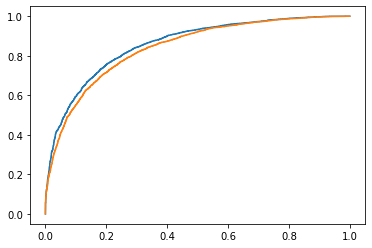

In [114]:
plt.plot(st_fpr, st_tpr)
plt.plot(mt_fpr, mt_tpr)

In [136]:
st_fpr, st_fnr, st_thresholds = draw_DET(predicts, gts)

In [130]:
mt_fpr, mt_fnr, mt_thresholds = draw_DET(predicts, gts)

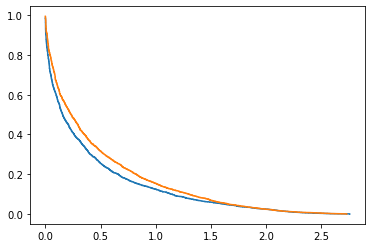

In [138]:
plt.plot(st_fpr* (10000/3600), st_fnr)
plt.plot(mt_fpr* (10000/3600), mt_fnr)

In [120]:
for threshold in [0.5]:
    predict2 = []
    gt2 = []
    for i, j in enumerate(predicts):
        predict2.append(float(j[0]))
        gt2.append(float(gts[i]))

    predict2 = np.array(predict2)
    gt2 = np.array(gt2)

    predict2[predict2 > 0.5] = 1
    predict2[predict2 <= 0.5] = 0
    gt2[gt2==0] = 0


    confusion_dictionary = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
    for i in range(len(predict2)):
        #print(predict2[i], gt2[i])
        if predict2[i] and gt2[i]:
            confusion_dictionary['TP'] += 1
        elif not predict2[i] and not gt2[i]:
            confusion_dictionary['TN'] += 1
        elif predict2[i] and not gt2[i]:
            confusion_dictionary['FP'] += 1
        elif not predict2[i] and gt2[i]:
            confusion_dictionary['FN'] += 1

    predict2 = predict2 > 0.3
    correct = sum(predict2 == gt2)
    accuracy = correct / len(gt2)
    recall = confusion_dictionary['TP'] / (confusion_dictionary['TP'] + confusion_dictionary['FN'])
    precision = confusion_dictionary['TP'] / (confusion_dictionary['TP'] + confusion_dictionary['FP'])
    print(f'accuracy: {accuracy*100}, recall: {recall}, precision: {precision}')
    #print(accuracy * 100)

accuracy: 75.46641791044776, recall: 0.7175732217573222, precision: 0.7713064987632111


In [118]:
st_confusion_dictionary = confusion_dictionary

In [121]:
mt_confusion_dictionary = confusion_dictionary

In [122]:
st_confusion_dictionary, mt_confusion_dictionary

({'TP': 3355, 'TN': 4051, 'FP': 744, 'FN': 1498},
 {'TP': 3430, 'TN': 3851, 'FP': 1017, 'FN': 1350})

In [33]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    predict2 = []
    gt2 = []
    for i, j in enumerate(predicts):
        predict2.append(float(j[0]))
        gt2.append(float(gts[i]))

    predict2 = np.array(predict2)
    gt2 = np.array(gt2)

    predict2[predict2 > threshold] = 1
    predict2[predict2 <= threshold] = 0
    gt2[gt2==0] = 0


    confusion_dictionary = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
    for i in range(len(predict2)):
        #print(predict2[i], gt2[i])
        if predict2[i] and gt2[i]:
            confusion_dictionary['TP'] += 1
        elif not predict2[i] and not gt2[i]:
            confusion_dictionary['TN'] += 1
        elif predict2[i] and not gt2[i]:
            confusion_dictionary['FP'] += 1
        elif not predict2[i] and gt2[i]:
            confusion_dictionary['FN'] += 1

    predict2 = predict2 > 0.3
    correct = sum(predict2 == gt2)
    accuracy = correct / len(gt2)
    recall = confusion_dictionary['TP'] / (confusion_dictionary['TP'] + confusion_dictionary['FN'])
    precision = confusion_dictionary['TP'] / (confusion_dictionary['TP'] + confusion_dictionary['FP'])
    print(f'accuracy: {accuracy*100}, recall: {recall}, precision: {precision}')
    #print(accuracy * 100)

accuracy: 74.77197346600332, recall: 0.894923012900541, precision: 0.6903691813804174
accuracy: 76.73092868988391, recall: 0.7546816479400749, precision: 0.7728531855955678
accuracy: 74.61650082918739, recall: 0.6371202663337495, precision: 0.8128484204937616
accuracy: 72.19112769485903, recall: 0.5384935497295048, precision: 0.8476907959384212
accuracy: 69.7035655058043, recall: 0.45588847274240535, precision: 0.876750700280112
accuracy: 66.3971807628524, recall: 0.3651685393258427, precision: 0.9018499486125385
accuracy: 62.63474295190713, recall: 0.2725759467332501, precision: 0.923185341789993
accuracy: 58.2089552238806, recall: 0.17103620474406991, precision: 0.9448275862068966
accuracy: 53.64842454394692, recall: 0.07074490220557636, precision: 0.9826589595375722


In [26]:
predict2 = []
gt2 = []
for i, j in enumerate(predicts):
    predict2.append(float(j[0]))
    gt2.append(float(gts[i]))

predict2 = np.array(predict2)
gt2 = np.array(gt2)

predict2[predict2 > threshold] = 1
predict2[predict2 <= threshold] = 0
gt2[gt2==0] = 0


confusion_dictionary = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
for i in range(len(predict2)):
    #print(predict2[i], gt2[i])
    if predict2[i] and gt2[i]:
        confusion_dictionary['TP'] += 1
    elif not predict2[i] and not gt2[i]:
        confusion_dictionary['TN'] += 1
    elif predict2[i] and not gt2[i]:
        confusion_dictionary['FP'] += 1
    elif not predict2[i] and gt2[i]:
        confusion_dictionary['FN'] += 1

predict2 = predict2 > 0.3
correct = sum(predict2 == gt2)
accuracy = correct / len(gt2)
recall = confusion_dictionary['TP'] / (confusion_dictionary['TP'] + confusion_dictionary['FN'])
print(f'recall: {recall}')
#print("Threshold: ", threshold, ", accuracy: ", accuracy)
#print(accuracy * 100)

print(confusion_dictionary)

recall: 0.3974989749897499
{'TP': 1939, 'TN': 4612, 'FP': 158, 'FN': 2939}


In [ ]:
falseAlarmperHour = 158 /((2939 + 1939) * (10000/3600))